<a href="https://colab.research.google.com/github/Francesca-Rossi/ITA_university_advisor/blob/main/IAuniversity_datset_completo_backup_1_06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1>PROGETTO DI BIG DATA E BUSSINESS INTELLIGENCE:</h1>

![](https://drive.google.com/uc?export=view&id=1akQN6cxOyAOmI5QRIw1VVnQUUIU8WFrT)
<p><i>An italian university advisor</i></p>
<p> A cura di Francesca Rossi e Martina Dominici </p>
</center>

<h4><b>1) Obiettivo della ricerca </b></h4>
<p>Lo scopo di questo progetto è creare un consigliatore di università triennali/magistrali a ciclo unico sfruttando la potenza del Machine Learning,aiutando nella scelta gli studenti delle scuole superiori.</p>


<h4><b>2) Stato dell'arte </b></h4>
<p>Questo argomento non presentava ricerche simili o uguali fatte in precedenza.Questo ha comportato inoltre che non fosse presente nemmeno un dataset,problema al quale abbiamo ovviato autoproducendolo.</p>

<h4><b>3) Strumenti utilizzati </b></h4>
<table>
<tr>
  <th>Strumento</th>
  <th>Descrizione</th>
  <th>Utilizzo</th>
</tr>
<tr>
<td>Google Apps Script</td>
</tr>
<tr>
<td>Google Sheets</td>
</tr>
<tr>
<td>Google Colab</td>
</tr>
<tr>
<td>Python</td>
</tr>
<tr>
<td>Pandas</td>
</tr>
<tr>
<td>Numpy</td>
</tr>
<tr>
<td>Sklearn</td>
</tr>
<tr>
<td>Nltk</td>
</tr>
<tr>
<td>MatplotLib</td>
</tr>
<tr>
<td>Seaborn</td>
</tr>
</table>

#<p>IMPORTAZIONI LIBRERIE</p>

In [198]:
import gspread 
import string
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import plot_confusion_matrix
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from collections import Counter
from numpy import where
from numpy import mean
from numpy import std
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
import os
from oauth2client.service_account import ServiceAccountCredentials
from google.colab import drive
from nltk.corpus import stopwords
from nltk.stem.snowball import ItalianStemmer
import json as js
import seaborn as sns


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#<p>FUNZIONI PRINCIPALI</p>

In [199]:
stop_ita = stopwords.words('italian')
stop_en = stopwords.words('english')
stemmer = ItalianStemmer()


#CLEANING DATA
def lang_stop_words(feature, lang):
  if (lang == "IT"):
    feature=feature.apply(lambda x: [item for item in x if item not in stop_ita]) 
  elif (lang == "EN"):
    feature=feature.apply(lambda x: [item for item in x if item not in stop_en]) 
  else:
    feature=feature.apply(lambda x: [item for item in x if item not in stop_ita])
    feature=feature.apply(lambda x: [item for item in x if item not in stop_en])
  return feature

def data_cleaning(feature, regex_list):
  feature=feature.apply(lambda x: x.lower()) #minuscolo
  feature=feature.str.strip() #eliminaz spazi bianchi inizio e fine
  for regex in regex_list:
    feature=feature.str.replace(regex, ' ')
    #feature=feature.str.replace(r'\s\s+', ' ') #eliminaz doppi spazi
  for char in string.punctuation:
    feature=feature.str.replace(char, ' ')
  return feature

#PREPROCESSING TEXT
def preprocessing_text(dataframe, feature, key, lang): 
  feature=feature.str.strip() #elimino spazi bianchi a inizio e fine
  feature =dataframe.apply(lambda row: nltk.word_tokenize(row[key]), axis=1)
  feature =lang_stop_words(feature, lang)
  feature=feature.apply(lambda x: [stemmer.stem(y) for y in x]) # Stem every word
  feature=feature.apply(' '.join)
  return feature

#FEATURE ENGINEERING TEXT 
def tf_vector(vectorize, feature):
  tf_matrix = vectorize.fit_transform(feature)
  tf_matrix = tf_matrix.toarray()
  vocab = vectorize.get_feature_names()
  return pd.DataFrame(np.round(tf_matrix, 2), columns=vocab)

def bag_of_words(vectorize,feature):
  vectorize.fit(feature)
  bag_array= vectorize.transform(feature).toarray()
  vocab = vectorize.get_feature_names()
  return pd.DataFrame(bag_array, columns=vocab)

#FEATURE ENGINEERING CATEGORICAL DATA
encoder = LabelEncoder()
def one_hot_encoding(feature, key):
  genre_labels = encoder.fit_transform(feature) 
  genre_mappings = {index: label for index, label in enumerate(encoder.classes_)}
  feature=genre_labels
  print('encoding', key, ':',  genre_mappings)
  return feature

#TRAINING DATASET
def fit_dataset(model, X_train, y_train, X_test):
  model.fit(X_train, y_train) # training the model on the train dataset
  predictions= model.predict(X_test) # predicting the output on the test dataset
  return predictions

def score_dataset(model, X_train, y_train, X_test, y_test):
  score_dict={}
  score_dict['score_train_set']=model.score(X_train, y_train)
  score_dict['score_test_set']=model.score(X_test, y_test)
  score_dict['lengh_train_set'] = round(len(X_train))
  score_dict['lengh_test_set'] = round(len(X_test))
  return score_dict

def wrong_classification(X_test, predictions, y_test):
  wrong_class=0
  for i in range(len(X_test)):
    elem = X_test[i]
    prediction = predictions[i]
    label = y_test[i]
    if prediction != label:
        wrong_class += 1
        print(i, 'has been classified as ', prediction, 'and should be ', label)
  print("-----------------------------------") 
  return wrong_class

#GRAPHS
# missing value
def missing_value_colors(values, tot):
  clrs=[]
  for x in values:
    x_perc= (x/tot)*100
    if (x_perc<=75):
      clrs.append('g') #green when missing value < 75%
    elif (x_perc>75) and (x_perc<=85):
      clrs.append('y')
    else:
      clrs.append('r')
  return clrs

def missing_value_graphs(dataframe_missing_value, original_df, title):
  #variable
  tot_values=original_df.shape[0] 
  print(tot_values)
  values=dataframe_missing_value.values
  row_index=dataframe_missing_value.index
  start=0
  for i in range(2, 0, -1):
    end=int(len(row_index)/i)
    title_str=f'{title} missing values from {row_index[start]} to {row_index[end-1]}'
    #graphs
    fig, ax = plt.subplots(figsize =(10, 12))
    colors=missing_value_colors(values, tot_values)
    ax.barh(row_index[start:end], values[start:end], color=colors[start:end])   # Horizontal Bar Plot
    ax.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.2)   # Add x, y gridlines
    for i in ax.patches: 
        plt.text(i.get_width()+0.2, i.get_y()+0.5,str(round(((i.get_width()/tot_values)*100), 2))+'%',
                fontsize = 10, fontweight ='bold',color ='grey')   # Add annotation to bars
    ax.invert_yaxis()   # Show top values
    #labeling
    plt.xlabel("Missing values")
    plt.ylabel("Features")
    plt.title(title_str)
    plt.show() #show the graphs
    start=end



#<h4>4) RECUPERO DEI DATI E COSTRUZIONE DATASET INIZIALE</h4>
<p>I dati per la ricerca sono stati raccolti utilizzando un <b>form autoprodotto</b>, successivamente memorizzati all'interno di un <b>file google sheets</b>.</p>



## <h5><b>4.1) Connessione con il foglio di google</b></h5>

In [200]:
SCOPES = ["https://spreadsheets.google.com/feeds",
                  "https://www.googleapis.com/auth/spreadsheets",
                  "https://www.googleapis.com/auth/drive",
                  "https://www.googleapis.com/auth/drive"]
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/Colab Notebooks/big data proj")
cred = ServiceAccountCredentials.from_json_keyfile_name("/content/drive/My Drive/Colab Notebooks/big data proj/GoogleSheetCredentials.json", SCOPES)
gclient = gspread.authorize(cred)
sheet = gclient.open_by_url("https://docs.google.com/spreadsheets/d/1scMc0UlNC1pdZNow5k3pLhofcW6j4ekXyxYlNiBcueI/edit?usp=sharing")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##<h5><b> 4.2) Creazione dei dataset iniziale</b></h5>

In [201]:
students_data = sheet.worksheet('Laureando').get_all_records()
graduate_data = sheet.worksheet('Laureato').get_all_records()

In [202]:
df_students = pd.DataFrame(students_data)
df_graduate = pd.DataFrame(graduate_data)
print("students shape:", df_students.shape )
print("graduates shape:", df_graduate.shape )

students shape: (719, 88)
graduates shape: (61, 85)


##<h5><b> 4.3) Rimozione features in eccesso</b> </h5>
<p> Abbiamo rimosso le features relative ad un altro progetto evitantando cosi di oberare la memoria con dati non significativi </p>

In [203]:
df_students = df_students.drop(df_students.loc[:, 'degree_course_class':'decision_choice_class'].columns, axis=1)
df_graduate = df_graduate.drop(df_graduate.loc[:, 'degree_course_class':'decision_choice_class'].columns, axis=1)
print("students shape:", df_students.shape )
print("graduates shape:", df_graduate.shape )

students shape: (719, 79)
graduates shape: (61, 76)


#<h4>5) PREPROCESSING E DATA CLEANING</h4>

##<h5><b> 5.1) Analisi dei valori mancanti </b></h5>

###<h5>5.1.1) Sostituzione celle vuote con valore 'Nan'</h6>

In [204]:
df_students=df_students.replace('',np.NaN)
df_graduate=df_graduate.replace('',np.NaN)

###<h5> 5.1.2) Somma valori mancanti per ogni features</h6>

In [205]:
df_missing_value_students=df_students.isnull().sum()
df_missing_value_graduate=df_graduate.isnull().sum()

### <h5> 5.1.3) DATASET STUDENTI: grafico valori mancanti</h6>


719


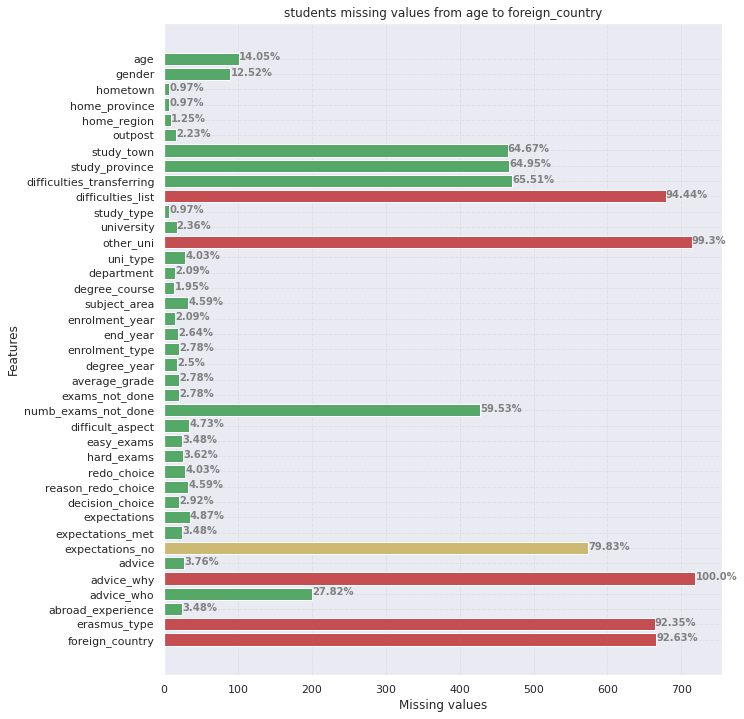

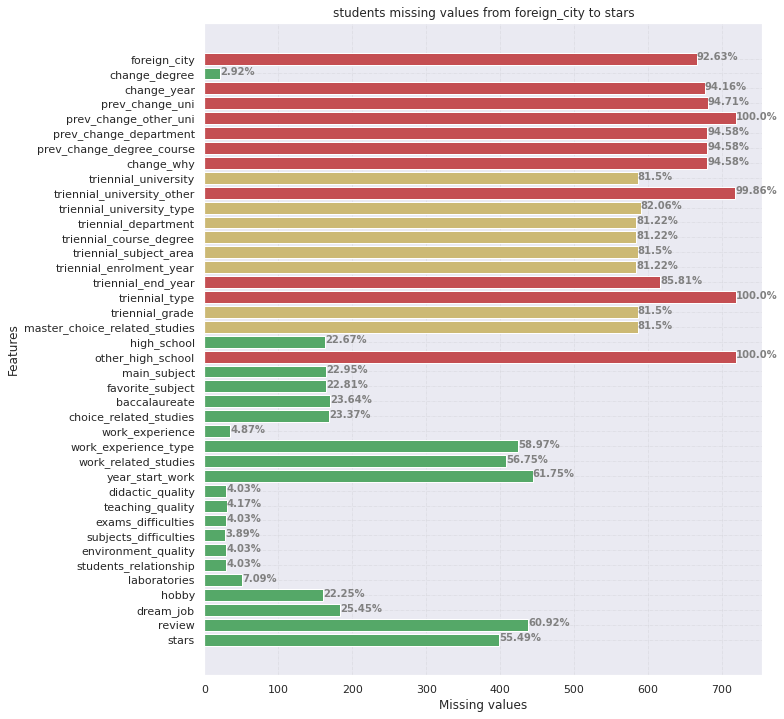

In [206]:
missing_value_graphs(df_missing_value_students, df_students, 'students')

### <h5> 5.1.4) LAUREATI: grafico valori mancanti </h6>

61


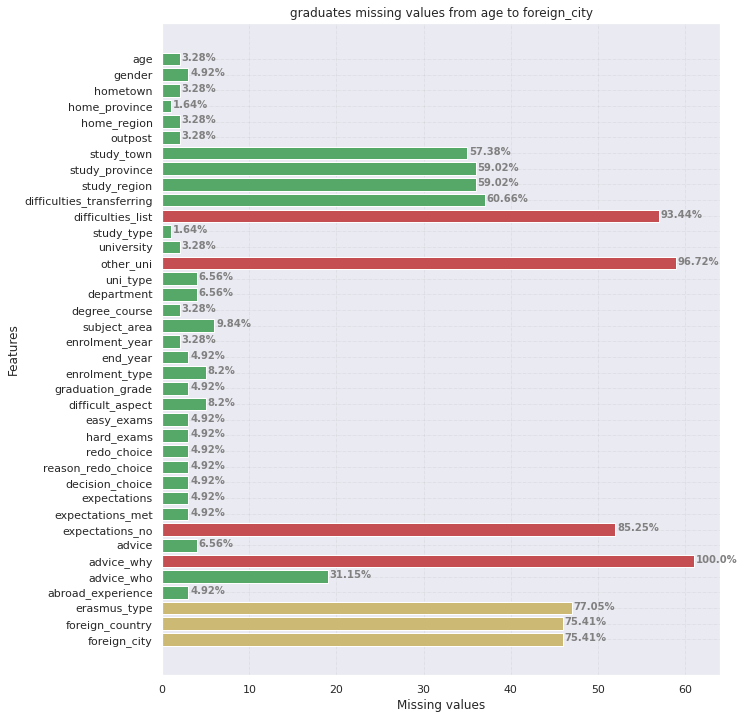

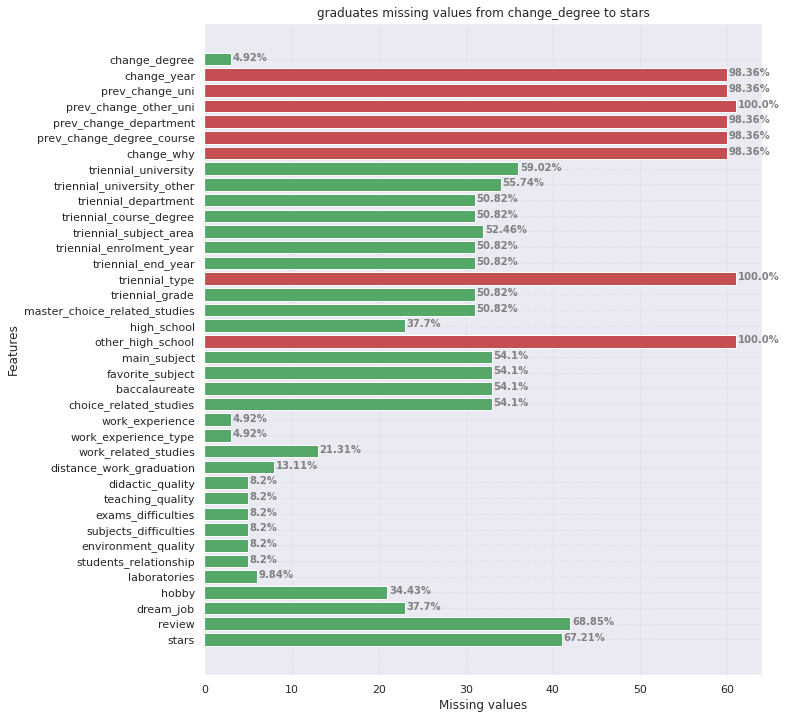

In [207]:
missing_value_graphs(df_missing_value_graduate, df_graduate, 'graduates')

##<h5><b> 5.2) Recupero dati triennali e magistrali a ciclo unico</b><h5>

<p>Dopo un'accurata analisi dei valori abbiamo riscontrato un numero molto elevato di valori mancanti relativi alle lauree specialistiche che non avrebbe permesso una predizione finale ottimale. Abbiamo perciò optato per continuare la nostra ricerca con le lauree di primo livello.</p>

In [208]:
query_first_degree='study_type == "Triennale" | study_type == "Magistrale_unico"'
df_students_first_degree = df_students.query(query_first_degree)
df_graduate_first_degree = df_graduate.query(query_first_degree)
print('students first degree:',df_students_first_degree.shape)
print('graduates first degree:',df_graduate_first_degree.shape)


students first degree: (568, 79)
graduates first degree: (29, 76)


### <h5>5.2.1) Analisi valori mancanti specifica per le lauree di primo livello</h5>

In [209]:
df_missing_value_first_degree_students=df_students_first_degree.isnull().sum()
df_missing_value_first_degree_graduate=df_graduate_first_degree.isnull().sum()

####<h6> 5.2.1.1) STUDENTI: grafico valori mancanti</h6>

568


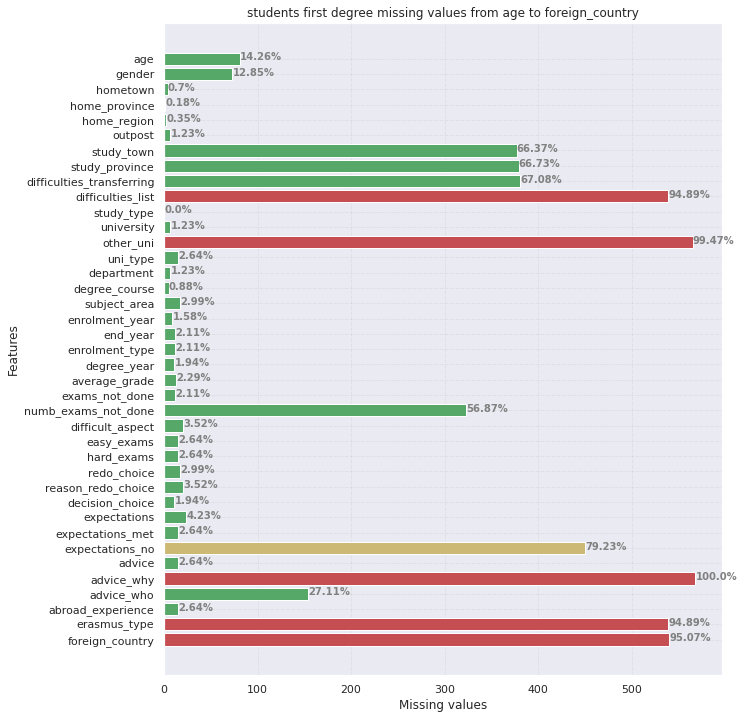

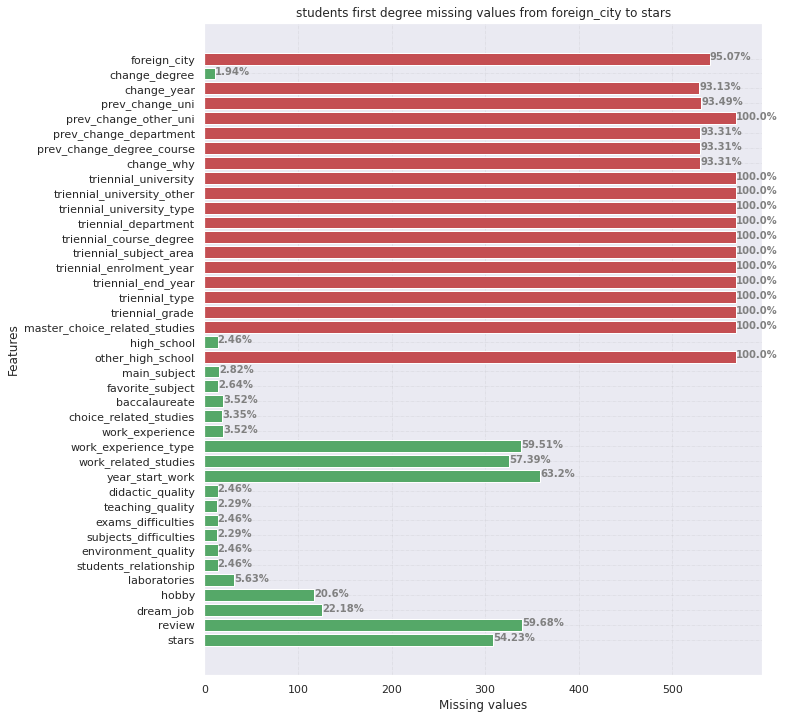

In [210]:
missing_value_graphs(df_missing_value_first_degree_students, df_students_first_degree, 'students first degree')

#### <h6> 5.2.1.2)LAUREATI: grafico valori mancanti </h6>

29


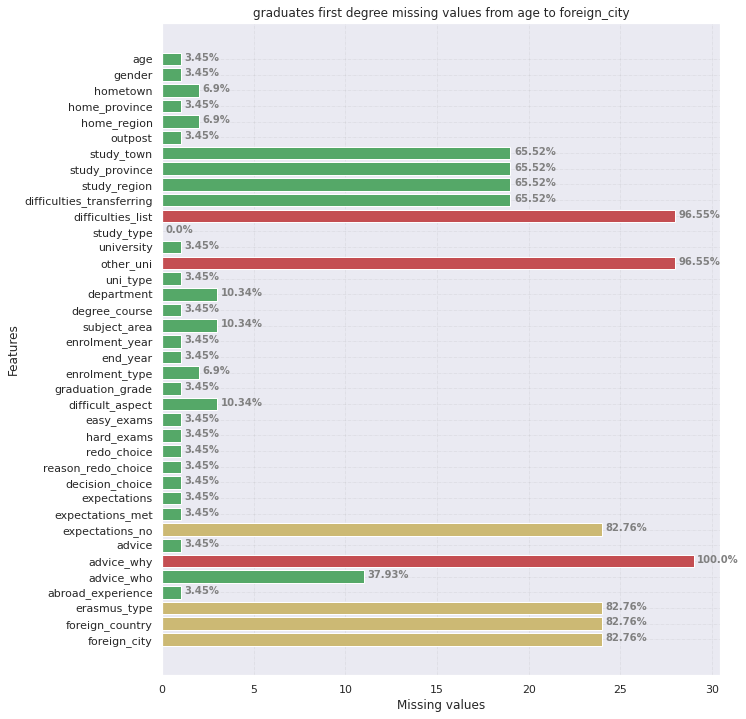

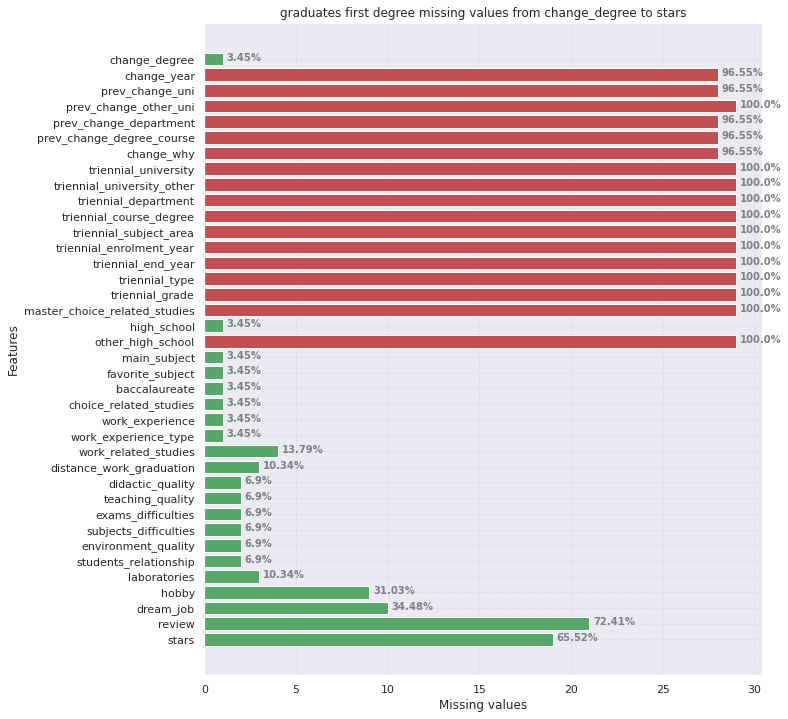

In [211]:
missing_value_graphs(df_missing_value_first_degree_graduate, df_graduate_first_degree, 'graduates first degree')

##<h5><b>5.3) Selezione delle features</b></h5>
<p>Dopo una seconda analisi specifica dei valori mancanti relativi alle lauree di primo livello, abbiamo selezionato le features più consone per il nostro obiettivo finale e con un numero di valori mancanti ridotto, quali:</p>
<ul>
<li>Main Subject</li>
<li>Favorite Subject</li>
<li>Main Subject</li>
<li>Dream job</li>
<li>Hobby</li>
<li>High school</li>
<li>Decision Choice</li>
<li>Expectations </li>
<li>Choice Related Studies</li>
</ul>
Inoltre abbiamo selezionato  <code> other high school </code> nel caso si aggiungesse qualche dato. Ovviamente questo campo sarà gestito e verrà mergiato assieme a high school nei prossimi passaggi

In [212]:
features_first_degree=['degree_course','other_high_school','high_school','main_subject', 'favorite_subject', 'dream_job', 'hobby', 'decision_choice' , 'expectations', 'choice_related_studies'  ]

###<h5> 5.3.1) Unione del dataset degli studenti con quello dei laureati per le features selezionate</h5>
<p>Poichè la nostra ricerca si concentrava sulle lauree di primo livello,abbiamo unito i dataset concernenti laureandi e laureati che rientravano nel target </p>
<p>AGGIUNGI QUALCOSA.....</p>

In [213]:
all_features_dict={}
for feature in features_first_degree:
  all_features=df_students_first_degree[feature]
  all_features=all_features.append(df_graduate_first_degree[feature], ignore_index=True, verify_integrity=True)
  all_features_dict[feature]=all_features

df_all_features_first_degree=pd.DataFrame(all_features_dict)
print('original sample first degree:',df_all_features_first_degree.shape[0] )
df_all_features_first_degree.head()

original sample first degree: 597


degree_course  ...  choice_related_studies
0  ingegneria aerospaziale  ...                      SI
1     Economia e commercio  ...                      NO
2                 Medicina  ...                      NO
3    Medicina e chirurgia   ...                      NO
4         Infermieristica   ...                      NO

[5 rows x 10 columns]

##<h5><b> 5.5) Features cleaning</b></h5>

###<h5> 5.5.1) Eliminazione valori nulli </h5>
<p> Avendo raccolto i dati di prima persona,creando un dataset autoprodotto, abbiamo avuto la necessità di visionare quanti e quali fossero i dati mancanti riguardo le lauree di primo livello</p>

In [214]:
#conto valori nulli
df_all_features_first_degree.isnull().sum()

degree_course               6
other_high_school         597
high_school                15
main_subject               17
favorite_subject           16
dream_job                 136
hobby                     126
decision_choice            12
expectations               25
choice_related_studies     20
dtype: int64

In [215]:
for key in all_features_dict:
  if key!='main_subject' and key!='other_high_school':
    df_all_features_first_degree = df_all_features_first_degree[df_all_features_first_degree[key].notna()]
print('sample first degree after delete null value:',df_all_features_first_degree.shape[0])

sample first degree after delete null value: 422


### <h5>5.5.2) Gestione valori mancanti del <code>main_subject</code><h5>
<p> Per gestire i valori mancanti delle materie principali, abbiamo ipotizzato che ciascuna categoria di scuole superiori abbia le stesse materie principali. </p>
<p> Conoscendo la scuola superiore, abbiamo creato un algoritmo in grado di replicare le materie mancanti data la scuola superiore. <br> In pratica, l'algoritmo cerca la prima riga non nulla contenete le materie principali relative a quella scuola superiore e le replica quando la stessa scuola superiore ha il campo della materia principale vuoto</p>


In [216]:
school_whitout_subject= df_all_features_first_degree['high_school'].loc[df_all_features_first_degree['main_subject'].isnull()]

In [217]:
full_subject=df_all_features_first_degree['main_subject']
high_school=np.array(df_all_features_first_degree['high_school'])
for x  in school_whitout_subject:
  subject=np.array(df_all_features_first_degree['main_subject'].loc[df_all_features_first_degree['high_school'].str.contains(x,na=False)][0:1])
  for i in range(0, len(high_school)):
    if (high_school[i]==x):
        full_subject[i]=np.array2string(subject)
df_all_features_first_degree['full_subject']=full_subject

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [218]:
df_all_features_first_degree['main_subject']=df_all_features_first_degree['main_subject'].combine_first(df_all_features_first_degree['full_subject'])
df_all_features_first_degree[['main_subject', 'full_subject']].head(50)

main_subject                                       full_subject
1                           matematica,fisica,scienze                          matematica,fisica,scienze
2                              Greco, latino,italiano                             Greco, latino,italiano
3                             Latino, greco, italiano                            Latino, greco, italiano
4    Greco, latino, italiano, letteratura, filosofia.   Greco, latino, italiano, letteratura, filosofia.
5       Diritto, economia inglese, francese, spagnolo      Diritto, economia inglese, francese, spagnolo
6                       Latino,greco,italiano,inglese                      ['matematica,fisica,scienze']
9                   Matematica,scienze,fisica,chimica                      ['matematica,fisica,scienze']
10                              Economia, informatica                              Economia, informatica
11  Matematica, fisica, italiano, chimica/scienze ...  Matematica, fisica, italiano, chimica/scienze ...
12                       Matematica, fisica, chimica                        Matematica, fisica, chimica 
14                 Scienze umane, filosofia, italiano                 Scienze umane, filosofia, italiano
16  Lingua spagnola, lingua tedesca, lingua ingles...                      ['matematica,fisica,scienze']
17              Economia, diritto, inglese, spagnolo               Economia, diritto, inglese, spagnolo 
19  Microbiologia ambientale, chimica organica ed ...  Microbiologia ambientale, chimica organica ed ...
20                             Latino, Greco, Scienze                      ['matematica,fisica,scienze']
21  Storia dell’arte, laboratorio audiovisivo, teo...                      ['matematica,fisica,scienze']
22                                 Matematica, Fisica                      ['matematica,fisica,scienze']
23           Matematica, Fisica, Informatica, Scienze           Matematica, Fisica, Informatica, Scienze
24           Matematica, scienze, fisica, letteratura           Matematica, scienze, fisica, letteratura
25             Economia aziendale, diritto, le lingue             Economia aziendale, diritto, le lingue
27              Latino, italiano, matematica, scienze              Latino, italiano, matematica, scienze
28  Matematica, scienze, italiano, inglese, fisica...                      ['matematica,fisica,scienze']
29                                Matematica , fisica                                Matematica , fisica
30  Greco, latino, letteratura italiana, storia e ...  Greco, latino, letteratura italiana, storia e ...
33  Visual Arts, Fisica, Matematica, Letteratura I...  Visual Arts, Fisica, Matematica, Letteratura I...
36                  Greco, Latino,Italiano, Filosofia                  Greco, Latino,Italiano, Filosofia
37                         Fisica, matematica, latino                         Fisica, matematica, latino
38  Greco, latino, italiano, storia, filosofia, ma...  Greco, latino, italiano, storia, filosofia, ma...
39                       Matematica, fisica, scienze                        Matematica, fisica, scienze 
41  Italiano, matematica, sistemi, tecnologie di p...  Italiano, matematica, sistemi, tecnologie di p...
43  Informatica, telecomunicazioni, tecnologie e p...  Informatica, telecomunicazioni, tecnologie e p...
44                                             Lingue                                             Lingue
45    Matematica, fisica, scienze, storia e filosofia    Matematica, fisica, scienze, storia e filosofia
46                                        Informatica                                        Informatica
47  Matematica,fisica,scienze,latino,disegno tecni...  Matematica,fisica,scienze,latino,disegno tecni...
48  Greco, latino, letteratura italiana, filosofia...  Greco, latino, letteratura italiana, filosofia...
49  Meccanica, disegno industriale, tecnologia mec...  Meccanica, disegno industriale, tecnologia mec...
50   Italiano, matematica, cucina, inglese, biologi

In [219]:
df_all_features_first_degree=df_all_features_first_degree.drop(['full_subject'], axis=1) #elimino colonna d'appoggio

Eliminazione eventuali valori nulli rimasti ed aggiunta al dizionario con il resto delle colonne pulite

In [220]:
df_all_features_first_degree = df_all_features_first_degree[df_all_features_first_degree['main_subject'].notna()] #eliminazioni eventuali valori nulli rimasti
print('sample first degree after delete null value:',df_all_features_first_degree.shape[0])

sample first degree after delete null value: 420


In [221]:
original_df_whitout_nan_value=df_all_features_first_degree.copy()

###<h5>5.5.3) Pulizia del target (<code>degree_course</code>)</h5>
<p>Poichè la nostra variabile target è stata immessa dall'utente come testo libero, abbiamo dovuto ripulirla per renderla pronta per la successiva feature engineering.</p>
<p>Oltre alle normali procedure di pulizia del testo (stemming, eliminazione stopwords...)è stato necessario: <ul> 
<li>sostituire gli acronimi (che abbiamo trovato analizzando i dati) con il relativo corso di laurea</li>
<li>eliminare parole speciali e fuorvianti quali "curriculum", "indirizzo", "L-22".....</li>
<li>Fare un ulteriore pulizia manuale delle lauree scritte male ( invertito il nome ecc...)</li>
</ul></p>
<p>Per quest'ultima pulizia più approfondita c'è stata utile la conoscienza del dominio</p>

In [222]:
#acronimi
slang_degree_course={"ctf":"chimica e tecnologie farmaceutiche",
       "clemi": "economia e marketing internazionale", 
       "sztpa": "scienze zootecniche e tecnologie delle produzioni animali", 
       "smid": "statistica matematica e trattamento informatico dati", 
       "clei": "economia internazionale",
       "clem": "economia e marketing", 
       "cle": "economia", 
       "dams": "discipline delle arti della musica e dello spettacolo",
       "ctc": "chimica e tecnologie chimiche",
       "pmts": "planning management of tourism systems",
       "eifi":  "lingue moderne comunicazione cooperazione internazionale",
       "lms":  "letteratura musica spettacolo"
        }
regex_degree_course=[r'\sl.*[0-9]+', r'\scurriculum\s.*', r'indirizzo.*', r'[(].*[)]*', r'&', r'\s\s+', r'corso di laurea', r'ciclo unico', r'’']

In [223]:
#elimino valori nulli
df_all_features_first_degree=df_all_features_first_degree[df_all_features_first_degree['degree_course'].notna()]

In [224]:
df_all_features_first_degree['degree_course']=data_cleaning(df_all_features_first_degree['degree_course'], regex_degree_course)
#sostituzione slang
for key in slang_degree_course.keys():
  df_all_features_first_degree.loc[df_all_features_first_degree['degree_course'].str.contains(key), 'degree_course'] = slang_degree_course[key]

#ulteriore pulizia manuale
df_all_features_first_degree.loc[df_all_features_first_degree['degree_course'].str.contains('medicina') & ~df_all_features_first_degree['degree_course'].str.contains('veterinaria'), 'degree_course'] = 'medicina e chirurgia'
df_all_features_first_degree.loc[df_all_features_first_degree['degree_course'].str.contains('informatica') & df_all_features_first_degree['degree_course'].str.contains('elettronica') & df_all_features_first_degree['degree_course'].str.contains('telecomunicazioni') , 'degree_course'] = 'ingegneria informatica elettronica e telecomunicazioni'
df_all_features_first_degree.loc[df_all_features_first_degree['degree_course'].str.contains('comunicazione e media per le industrie creative'), 'degree_course'] = 'comunicazione e media contemporanei per le industrie creative'
df_all_features_first_degree.loc[df_all_features_first_degree['degree_course'].str.contains('elettronica') & ~df_all_features_first_degree['degree_course'].str.contains('ingegneria' )& ~df_all_features_first_degree['degree_course'].str.contains('ing'), 'degree_course'] = 'ingegneria elettronica'
df_all_features_first_degree.loc[df_all_features_first_degree['degree_course'].str.contains('interfacce e tecnologie della comunicazion'), 'degree_course'] = 'interfacce uomo macchina e tecnologie della comunicazione'
df_all_features_first_degree.loc[df_all_features_first_degree['degree_course'].str.contains('letteratura musica e spettacolo'), 'degree_course'] = 'letteratura musica e spettacolo'
df_all_features_first_degree['degree_course']=df_all_features_first_degree['degree_course'].str.replace(r'(^ingegneria\s*)|(^ingegneria)', 'ing ')
df_all_features_first_degree['degree_course']=df_all_features_first_degree['degree_course'].str.replace('ingeneria ', 'ing ')
df_all_features_first_degree['degree_course']

1                        economia e commercio
2                        medicina e chirurgia
3                        medicina e chirurgia
4                             infermieristica
5      montaggio cinematografico e televisivo
                        ...                  
590                           ing informatica
591                                      ing 
592                      medicina e chirurgia
594                           scienze motorie
596               beni culturali e spettacolo
Name: degree_course, Length: 420, dtype: object

In [225]:
df_all_features_first_degree['degree_course']=preprocessing_text(df_all_features_first_degree, df_all_features_first_degree['degree_course'], 'degree_course', 'IT-EN')

In [226]:
unique_degree_course=np.unique(df_all_features_first_degree['degree_course'])
print(len(unique_degree_course))
print(unique_degree_course)

144
['archeolog' 'architettur' 'arti scienz spettacol' 'autom industrial'
 'ben artist spettacol' 'ben cultural' 'ben cultural spettacol' 'biolog'
 'biolog molecol' 'biotecnolog' 'chimic' 'chimic tecnolog chimic'
 'chimic tecnolog farmaceut' 'civilt lingu stran mod' 'comun' 'comun med'
 'comun med contemporane industr creativ' 'comun med pubblic' 'design'
 'design prodott industrial' 'dietist' 'digital marketing'
 'direzion impres' 'diritt tecnolog' 'disciplin arti music spettacol'
 'econom' 'econom amministr impres' 'econom aziendal' 'econom commerc'
 'econom finanz' 'econom internazional' 'econom management'
 'econom management nuov tecnolog digital'
 'econom marketing internazional' 'econom marketing management'
 'econom merc digital' 'econom merc istitu' 'economì management' 'farmac'
 'filosof' 'fisic' 'food system' 'gestion aziendal' 'giurisprudt'
 'graphic design' 'infermierist' 'informat' 'ing' 'ing ambiental'
 'ing biomed' 'ing chimic material' 'ing civil ambiental edil'
 'ing 

###<h5>5.5.5) Unione tra <code>high_school</code> e <code>other_high_school</code></h5>
<p> Questa unione è stata pensata nel caso in cui un studente frequentasse una scuola superiore particolare, che non fa parte dell'elenco che abbiamo fornito agli studenti</p>



In [227]:
df_all_features_first_degree['high_school']=df_all_features_first_degree['high_school'].replace('altro', np.NaN ) #necessario per effettuare merge tra 2 colonne


In [228]:
df_all_features_first_degree['high_school']=df_all_features_first_degree['high_school'].combine_first(df_all_features_first_degree['other_high_school'])

In [229]:
df_all_features_first_degree['high_school']=df_all_features_first_degree['high_school'].replace(np.NaN,'altro')

In [230]:
df_all_features_first_degree=df_all_features_first_degree.drop(['other_high_school'], axis=1) #elimino colonna d'appoggio
df_all_features_first_degree.head()

degree_course  ... choice_related_studies
1                econom commerc  ...                     NO
2               medicin chirurg  ...                     NO
3               medicin chirurg  ...                     NO
4                  infermierist  ...                     NO
5  montagg cinematograf televis  ...                     NO

[5 rows x 9 columns]

### <h5>5.5.6) Controllo finale che non ci siano più valori nulli</h5>

In [231]:
df_all_features_first_degree.isnull().sum()

degree_course             0
high_school               0
main_subject              0
favorite_subject          0
dream_job                 0
hobby                     0
decision_choice           0
expectations              0
choice_related_studies    0
dtype: int64

##<h5><b>5.6) Pulizia delle features</b></h5>
<p> In questa fase abbiamo pulito tutte le features del nostro dataset. Poichè le nostre caratteristiche sono testuali/categoriali, abbiamo proveduto a:</p>
<ul>
<li>Mettere tutte le parole in minuscolo</li>
<li>Eliminare la punteggiatura</li>
<li>Eliminare caratteri speciali o spazi bianchi in eccesso</li>
<li>Stemming: estrazione della radice dalle parole (solo per le carateristiche testuali)</li>
<li>Eliminazione delle stopwords->parole inutili ai fini dell'analisi, come le congiunzioni</li>
<li>Tokenization: trasformazione delle parole in token (solo per le caratteristiche testuali)
</ul>

In [232]:
df_clean_features=df_all_features_first_degree.copy()

In [233]:
categorical_features=['high_school', 'choice_related_studies']
regex_features=[r'\s\s+']
for feature in df_clean_features.columns:
  if feature != 'degree_course':
    df_clean_features[feature]=data_cleaning(df_clean_features[feature], regex_features)
    if feature not in categorical_features:
      df_clean_features[feature]=preprocessing_text(df_clean_features,df_clean_features[feature], feature, 'IT')

In [234]:
for feature in df_clean_features.columns: 
  display(pd.merge(df_all_features_first_degree[feature], df_clean_features[feature], right_index = True,left_index = True))

degree_course_x               degree_course_y
1                  econom commerc                econom commerc
2                 medicin chirurg               medicin chirurg
3                 medicin chirurg               medicin chirurg
4                    infermierist                  infermierist
5    montagg cinematograf televis  montagg cinematograf televis
..                            ...                           ...
590                  ing informat                  ing informat
591                           ing                           ing
592               medicin chirurg               medicin chirurg
594                  scienz motor                  scienz motor
596        ben cultural spettacol        ben cultural spettacol

[420 rows x 2 columns]

high_school_x               high_school_y
1             Liceo Scientifico           liceo scientifico
2                Liceo Classico              liceo classico
3                Liceo Classico              liceo classico
4                Liceo Classico              liceo classico
5    Istituto tecnico economico  istituto tecnico economico
..                          ...                         ...
590           Liceo Scientifico           liceo scientifico
591   Istituto tecnico geometri   istituto tecnico geometri
592           Liceo Scientifico           liceo scientifico
594  Istituto tecnico economico  istituto tecnico economico
596                       IPSIA                       ipsia

[420 rows x 2 columns]

main_subject_x                                     main_subject_y
1                            matematica,fisica,scienze                               matemat fisic scienz
2                               Greco, latino,italiano                                    grec latin ital
3                              Latino, greco, italiano                                    latin grec ital
4     Greco, latino, italiano, letteratura, filosofia.                 grec latin ital letteratur filosof
5        Diritto, economia inglese, francese, spagnolo               diritt econom ingles frances spagnol
..                                                 ...                                                ...
590                   Matematica, Scienze, Informatica                            matemat scienz informat
591  Costruzioni, topografia, disegno, tecnologia d...     costruzion topograf disegn tecnolog costruzion
592                                           Scienze                                              scienz
594                                        Ragioneria                                            ragioner
596  Disegno per la moda, modellistica e confezione...  disegn mod modellist confezion stor mod stor arte

[420 rows x 2 columns]

favorite_subject_x             favorite_subject_y
1                                           matematica                        matemat
2                                     Non ne avevo una                               
3                                              Latino                           latin
4                                           Filosofia                         filosof
5                                              Diritto                         diritt
..                                                 ...                            ...
590                                          Filosofia                        filosof
591                                        costruzioni                     costruzion
592                                        Matematica                         matemat
594                                          Italiano                            ital
596  Disegno per la moda, storia della moda e stori...  disegn mod stor mod stor arte

[420 rows x 2 columns]

dream_job_x                      dream_job_y
1                               consulente finanziario              consulent finanziar
2                                            Radiologo                         radiolog
3                   Diventare un medico specializzato           divent medic specializz
4                        Infermiere di sala operatoria              inferm sal operator
5                           Montatrice cinematografica           montatric cinematograf
..                                                 ...                              ...
590                                       Imprenditore                      imprenditor
591          calcio professionistico (come allenatore)         calc professionist allen
592                                            Medico                             medic
594                                   Palestra salute                       palestr sal
596  Diventare una figurinista di moda o designer d...  divent figurin mod designer mod

[420 rows x 2 columns]

hobby_x                                  hobby_y
1                                          videogiochi                                videogioc
2                        Ascoltare musica, vedere film                    ascolt music ved film
3                                             Atletica                                    atlet
4                         Musica (batteria), biliardo.                     music batter biliard
5                Cinema, viaggi, lettura, arte, musica            cinem viagg lettur arte music
..                                                 ...                                      ...
590  Calcio, amici, programmazione web, investiment...     calc amic programm web invest finanz
591                                    calcio, lettura                              calc lettur
592                                              Nuoto                                     nuot
594                                Fotografia, animali                          fotograf animal
596  Viaggiare, leggere tanto, disegnare moda e asc...  viagg legg tant disegn mod ascolt music

[420 rows x 2 columns]

decision_choice_x             decision_choice_y
1    la mia voglia di intraprendere questo percorso...  vogl intraprend percors stud
2                      La predisposizione alla materia          predisposizion mater
3               Ho sempre voluto fare questo mestiere             sempr vol far mest
4    Il desiderio di poter dare una mano a chi ne h...  desider poter dar man bisogn
5                La mia grande passione per il cinema            grand passion cinem
..                                                 ...                           ...
590                  Consciamente nessuno mi ha spinto            consc nessun spint
591         Era la prosecuzione degli studi precedenti        prosecu stud precedent
592                                                  X                             x
594                                  Il mio interesse                       interess
596      Passione per la storia e la storia dell'arte         passion stor stor arte

[420 rows x 2 columns]

expectations_x                                     expectations_y
1                               quello che sto vivendo                                                viv
2                Di riuscire a proseguire con facilità                                riusc prosegu facil
3    Sicuramente lungo e faticoso ma spero soddisfa...             sicur lung fatic sper soddisfacent fin
4    Tutto quello che ho effettivamente incontrato ...  effett incontr percors fors men mater umanist ...
5    Mi aspettavo di riuscire ad imparare un mestie...           aspett riusc impar mest molt cors pratic
..                                                 ...                                                ...
590  Forse speravo di programmare un po' di più. Av...  fors sper programm po prefer far progett men esam
591                              Quello che ho trovato                                               trov
592                                                  X                                                  x
594                       Più pratica ma va bene così                                   pratic va ben cos
596                     Materie più attinenti al corso                                mater attinent cors

[420 rows x 2 columns]

choice_related_studies_x choice_related_studies_y
1                         NO                       no
2                         NO                       no
3                         NO                       no
4                         NO                       no
5                         NO                       no
..                       ...                      ...
590                       SI                       si
591                       SI                       si
592                       SI                       si
594                       NO                       no
596                       SI                       si

[420 rows x 2 columns]

#<h4> 6)FEATURES BUILDING</h4>

##<h5><b>6.1) Variabile target-> <code>degree_course</code></b></h5>
<p>Per i corsi di laurea è stato usato un algoritmo di clustering con lo scopo di raggruppare i corsi di laurea  in vari cluster contenenti quelli più simili testualmente tra di loro. Sono stati fatti 120 cluster.</p>
<p>Inanzitutto abbiamo utilizzato la <b>text-analysis con il modello tf-id</b>, che è più preciso del modello bag of words in quanto tiene conto dell'ordine dei token nella frase. In questo caso per noi era importante l'ordinamento, in quanto "ingegneria informatica" dovrà risultare in un cluster diverso da "informatica" ad esempio.</p>
<p>Successivamente abbiamo sfruttato l'algoritmo di <b>cosine similarity</b>, che permette di calcolare la distanza tra una parola e l'altra</p>
<p>Infine abbiamo applicato l'algoritmo <b>KMeans</b>, per effettuare i vari gruppi</p>
<p>Per concludere abbiamo soprannominato ogni gruppo con il nome originale (non pulito) della sua prima laurea, per semplificare la visualizzazione dei grafici finali di valutazione del modello</p>

In [235]:
tv = TfidfVectorizer(min_df=0., max_df=1., use_idf=True)
vectorize_matrix=tf_vector(tv, df_clean_features['degree_course'])
vectorize_matrix

alimentar  ambient  ambiental  amministr  ...  uman  uom  veterinar  zootecn
0          0.0      0.0        0.0        0.0  ...   0.0  0.0        0.0      0.0
1          0.0      0.0        0.0        0.0  ...   0.0  0.0        0.0      0.0
2          0.0      0.0        0.0        0.0  ...   0.0  0.0        0.0      0.0
3          0.0      0.0        0.0        0.0  ...   0.0  0.0        0.0      0.0
4          0.0      0.0        0.0        0.0  ...   0.0  0.0        0.0      0.0
..         ...      ...        ...        ...  ...   ...  ...        ...      ...
415        0.0      0.0        0.0        0.0  ...   0.0  0.0        0.0      0.0
416        0.0      0.0        0.0        0.0  ...   0.0  0.0        0.0      0.0
417        0.0      0.0        0.0        0.0  ...   0.0  0.0        0.0      0.0
418        0.0      0.0        0.0        0.0  ...   0.0  0.0        0.0      0.0
419        0.0      0.0        0.0        0.0  ...   0.0  0.0        0.0      0.0

[420 rows x 142 columns]

In [236]:
similarity_matrix = cosine_similarity(vectorize_matrix)
similarity_df = pd.DataFrame(similarity_matrix)
similarity_df.head()

0    1    2    3    4    5    6    ...  413  414  415  416  417  418  419
0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1  0.0  1.0  1.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  1.0  0.0  0.0
2  0.0  1.0  1.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  1.0  0.0  0.0
3  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0
4  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[5 rows x 420 columns]

In [237]:
km = KMeans(n_clusters=120, random_state=0)
km.fit_transform(similarity_df)
cluster_labels = km.labels_
cluster_labels_degree_course = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
df_clean_features= df_clean_features.set_index(cluster_labels_degree_course.index) #evita che escano valori NAN a causa di index diversi
cluster_labels_degree_course.insert(0,'degree_course',df_clean_features['degree_course'], True)
original_df_whitout_nan_value= original_df_whitout_nan_value.set_index(cluster_labels_degree_course.index) #evita che escano valori NAN a causa di index diversi
cluster_labels_degree_course.insert(0,'full_degree_course',original_df_whitout_nan_value['degree_course'], True)
byCluster=cluster_labels_degree_course.groupby(['ClusterLabel'])


In [238]:
labels = []
for cluster, degree in byCluster:
    print(f"All entries for {cluster!r}")
    print("------------------------")
    print(degree, end="\n\n")   #display(degree)
    labels.append(degree['full_degree_course'].iloc[0])
print(labels)

All entries for 0
------------------------
    full_degree_course degree_course  ClusterLabel
125        Archeologia     archeolog             0

All entries for 1
------------------------
            full_degree_course degree_course  ClusterLabel
29      Ingegneria informatica  ing informat             1
30      Ingegneria Informatica  ing informat             1
33      Ingegneria informatica  ing informat             1
74      Ingegneria informatica  ing informat             1
91            Ing. Informatica  ing informat             1
106     Ingegneria informatica  ing informat             1
121     ingegneria informatica  ing informat             1
142    Ingegneria informatica   ing informat             1
170     Ingegneria Informatica  ing informat             1
183     Ingegneria informatica  ing informat             1
191     ingegneria informatica  ing informat             1
198     Ingegneria informatica  ing informat             1
224     Ingegneria Informatica  ing informat

In [239]:
df_clean_features=df_clean_features.set_index(cluster_labels_degree_course.index)
df_clean_features['degree_course']=cluster_labels_degree_course['ClusterLabel']
print('check if add missing values:', df_clean_features['degree_course'].isnull().sum())

check if add missing values: 0


##<h5><b> 6.2) Caratteristiche categoriali <b></h5>
<p> Per codificare delle caratteristiche categoriali e binomiali, abbiamo usato l'algoritmo di <code>one hot encoding</code></p>

In [240]:
for feature in categorical_features:
  df_clean_features[feature]=one_hot_encoding( df_clean_features[feature], feature)

encoding high_school : {0: 'altro', 1: 'ipsia', 2: 'istituto professionale agrario ', 3: 'istituto professionale alberghiero', 4: 'istituto professionale economico ', 5: 'istituto tecnico agrario', 6: 'istituto tecnico alberghiero', 7: 'istituto tecnico economico', 8: 'istituto tecnico geometri', 9: 'istituto tecnico industriale', 10: 'liceo artistico', 11: 'liceo classico', 12: 'liceo linguistico', 13: 'liceo musicale', 14: 'liceo scientifico', 15: 'liceo scienze umane'}
encoding choice_related_studies : {0: 'no', 1: 'si'}


##<h5><b>6.3) Caratteristiche testuali-> text analysis</b></h5>
<p>Abbiamo deciso di utilizzare due modelli per codificare le variabili testuali: il modello <code> Bag of words </code> e il modello <code> TF-IDF</code></p>
<p> La differenza principale tra i due modelli è che il secondo è più accurato in quanto considera l'ordine in cui compaiono le parole nelle frasi</p>

### <h5>6.3.1) Modello bag of words</h5>
<p>Questo modello è stato utilizzato per tutte quelle features contenenti un elenco testuale, quindi in cui non era importante l'ordine ai fini del significato finale. Ad esempio:</p>
<ul>
<li> Le materie principali</li>
<li> Le materie preferite</li>
<li> Gli hobby</li>
<li> Il lavoro sognato <li>
</ul>


In [241]:
#Raggruppo tutte le colonne per il bag of word in un unica e da lista la converto in stringhe
df_clean_features['bag_of_words']=df_clean_features[['main_subject', 'hobby' , 'favorite_subject', 'dream_job' ]].values.tolist()
for index in df_clean_features['bag_of_words'].index:
  item=df_clean_features['bag_of_words'].iloc[index]
  listToStr = ' '.join([str(i) for i in item])
  df_clean_features['bag_of_words'].iloc[index]=listToStr

#df_clean_features['bag_of_words'].head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [242]:
#addestro il modello
vectorizer_train = CountVectorizer(min_df=0, binary=True)
df_bow_dict=bag_of_words(vectorizer_train, df_clean_features['bag_of_words'])
df_bow_dict

118  3d  abbandon  accadem  accoglit  ...  world  yog  york  zon  zootecn
0      0   0         0        0         0  ...      0    0     0    0        0
1      0   0         0        0         0  ...      0    0     0    0        0
2      0   0         0        0         0  ...      0    0     0    0        0
3      0   0         0        0         0  ...      0    0     0    0        0
4      0   0         0        0         0  ...      0    0     0    0        0
..   ...  ..       ...      ...       ...  ...    ...  ...   ...  ...      ...
415    0   0         0        0         0  ...      0    0     0    0        0
416    0   0         0        0         0  ...      0    0     0    0        0
417    0   0         0        0         0  ...      0    0     0    0        0
418    0   0         0        0         0  ...      0    0     0    0        0
419    0   0         0        0         0  ...      0    0     0    0        0

[420 rows x 911 columns]

In [243]:
df_clean_features=df_clean_features.drop(['main_subject', 'hobby' , 'favorite_subject', 'dream_job', 'bag_of_words'], axis=1)


In [244]:
df_clean_features.head() #controllo

degree_course  ...  choice_related_studies
0             57  ...                       0
1              2  ...                       0
2              2  ...                       0
3             14  ...                       0
4            108  ...                       0

[5 rows x 5 columns]

In [245]:
df_clean_features=df_clean_features.set_index(df_bow_dict.index)
df_clean_features=pd.concat([df_clean_features,  df_bow_dict], axis=1)


In [246]:
df_clean_features.head()


degree_course  high_school               decision_choice  ... york  zon  zootecn
0             57           14  vogl intraprend percors stud  ...    0    0        0
1              2           11          predisposizion mater  ...    0    0        0
2              2           11            sempr vol far mest  ...    0    0        0
3             14           11  desider poter dar man bisogn  ...    0    0        0
4            108            7           grand passion cinem  ...    0    0        0

[5 rows x 916 columns]

In [247]:
df_clean_features.shape

(420, 916)

In [248]:
df_clean_features.isnull().sum()

degree_course             0
high_school               0
decision_choice           0
expectations              0
choice_related_studies    0
                         ..
world                     0
yog                       0
york                      0
zon                       0
zootecn                   0
Length: 916, dtype: int64

###<h5>6.3.2) Modello TF-IDF</h5>
<p>Questo modello è stato usato per codificare le features contenenti frasi. Nelle frasi l'ordine delle parole è importante in quanto il significato può cambiare</p>
<p>Quindi abbiamo utilizzato questo modello, per codificare:</p>
<ul>
<li> Le aspettative</li>
<li> Il motivo della scelta</li>
</ul>

In [249]:
df_clean_features['tf_if']=df_clean_features[['expectations', 'decision_choice']].values.tolist()
for index in df_clean_features['tf_if'].index:
  item=df_clean_features['tf_if'].iloc[index]
  listToStr = ' '.join([str(i) for i in item])
  df_clean_features['tf_if'].iloc[index]=listToStr


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [250]:
tv = TfidfVectorizer(min_df=0., max_df=1., use_idf=True)
df_tf_id=tf_vector(tv, df_clean_features['tf_if'])
df_tf_id

15  2015   25  360  abbast  ...  workshop  youtub  zon  zoolog  zootecn
0    0.0   0.0  0.0  0.0    0.00  ...       0.0     0.0  0.0     0.0      0.0
1    0.0   0.0  0.0  0.0    0.00  ...       0.0     0.0  0.0     0.0      0.0
2    0.0   0.0  0.0  0.0    0.00  ...       0.0     0.0  0.0     0.0      0.0
3    0.0   0.0  0.0  0.0    0.25  ...       0.0     0.0  0.0     0.0      0.0
4    0.0   0.0  0.0  0.0    0.00  ...       0.0     0.0  0.0     0.0      0.0
..   ...   ...  ...  ...     ...  ...       ...     ...  ...     ...      ...
415  0.0   0.0  0.0  0.0    0.00  ...       0.0     0.0  0.0     0.0      0.0
416  0.0   0.0  0.0  0.0    0.00  ...       0.0     0.0  0.0     0.0      0.0
417  0.0   0.0  0.0  0.0    0.00  ...       0.0     0.0  0.0     0.0      0.0
418  0.0   0.0  0.0  0.0    0.00  ...       0.0     0.0  0.0     0.0      0.0
419  0.0   0.0  0.0  0.0    0.00  ...       0.0     0.0  0.0     0.0      0.0

[420 rows x 1019 columns]

In [251]:
df_clean_features=df_clean_features.drop(['expectations', 'decision_choice', 'tf_if'], axis=1)

In [252]:
df_clean_features=df_clean_features.set_index(df_tf_id.index)
df_clean_features=pd.concat([df_clean_features,  df_tf_id], axis=1)

In [253]:
df_clean_features.head()

degree_course  high_school  choice_related_studies  ...  zon  zoolog  zootecn
0             57           14                       0  ...  0.0     0.0      0.0
1              2           11                       0  ...  0.0     0.0      0.0
2              2           11                       0  ...  0.0     0.0      0.0
3             14           11                       0  ...  0.0     0.0      0.0
4            108            7                       0  ...  0.0     0.0      0.0

[5 rows x 1933 columns]

In [254]:
df_clean_features.shape

(420, 1933)

In [255]:
df_clean_features.isnull().sum()

degree_course             0
high_school               0
choice_related_studies    0
118                       0
3d                        0
                         ..
workshop                  0
youtub                    0
zon                       0
zoolog                    0
zootecn                   0
Length: 1933, dtype: int64

#<h4>7) Creazione del dataset

In [256]:
X=df_clean_features.iloc[:, 1:]
y=df_clean_features['degree_course']

In [257]:
X

high_school  choice_related_studies  118  3d  ...  youtub  zon  zoolog  zootecn
0             14                       0    0   0  ...     0.0  0.0     0.0      0.0
1             11                       0    0   0  ...     0.0  0.0     0.0      0.0
2             11                       0    0   0  ...     0.0  0.0     0.0      0.0
3             11                       0    0   0  ...     0.0  0.0     0.0      0.0
4              7                       0    0   0  ...     0.0  0.0     0.0      0.0
..           ...                     ...  ...  ..  ...     ...  ...     ...      ...
415           14                       1    0   0  ...     0.0  0.0     0.0      0.0
416            8                       1    0   0  ...     0.0  0.0     0.0      0.0
417           14                       1    0   0  ...     0.0  0.0     0.0      0.0
418            7                       0    0   0  ...     0.0  0.0     0.0      0.0
419            1                       1    0   0  ...     0.0  0.0     0.0      0.0

[420 rows x 1932 columns]

In [258]:
y

0       57
1        2
2        2
3       14
4      108
      ... 
415      1
416     48
417      2
418     72
419     52
Name: degree_course, Length: 420, dtype: int32

##<h5><b>7.1) Bilanciamento delle classi</b></h5>
<p> Poichè le nostre classi (i corsi di laurea) non sono rappresentate in modo approssimativamente uguale, è stato necessario bilanciare le classi. In questa fase il nostro obiettivo è perdere meno dati possibili, quindi abbiamo escluso un <code>algoritmo di undersampling</code>, che andava a ridurre il numero dei campioni nelle classi più numerose, e abbiamo optato per un' <code>algoritmo di oversampling</code>, che invece si occupa di aumentare il numero dei campioni delle classi meno numerose.</p>
<p> In particolare abbiamo usato <code>l'algoritmo RandomOverSampler</code> della libreria <i>imblearn</i></p>

In [259]:
print(Counter(y))
oversample = RandomOverSampler(sampling_strategy='auto')
X, y= oversample.fit_resample(X, y)
print(Counter(y))

Counter({2: 30, 1: 21, 3: 18, 12: 17, 6: 15, 4: 13, 15: 10, 13: 10, 5: 9, 11: 9, 14: 8, 39: 8, 52: 8, 25: 7, 31: 7, 30: 6, 28: 6, 29: 6, 21: 6, 26: 6, 33: 5, 17: 5, 37: 5, 60: 4, 63: 4, 75: 4, 32: 4, 35: 4, 70: 4, 36: 4, 8: 4, 50: 4, 43: 4, 19: 4, 49: 4, 20: 4, 71: 3, 16: 3, 22: 3, 41: 3, 44: 3, 65: 3, 9: 3, 66: 3, 57: 2, 61: 2, 42: 2, 56: 2, 10: 2, 58: 2, 79: 2, 46: 2, 38: 2, 62: 2, 51: 2, 64: 2, 114: 2, 80: 2, 78: 2, 93: 2, 59: 2, 82: 2, 27: 2, 87: 2, 55: 2, 34: 2, 72: 2, 116: 2, 77: 2, 24: 2, 48: 2, 83: 2, 45: 2, 67: 2, 54: 2, 23: 2, 40: 2, 108: 1, 118: 1, 111: 1, 47: 1, 90: 1, 95: 1, 94: 1, 117: 1, 101: 1, 97: 1, 92: 1, 91: 1, 105: 1, 98: 1, 110: 1, 74: 1, 107: 1, 0: 1, 106: 1, 69: 1, 86: 1, 7: 1, 100: 1, 104: 1, 99: 1, 115: 1, 73: 1, 112: 1, 113: 1, 89: 1, 18: 1, 53: 1, 119: 1, 68: 1, 88: 1, 76: 1, 109: 1, 103: 1, 81: 1, 102: 1, 85: 1, 84: 1, 96: 1})
Counter({57: 30, 2: 30, 14: 30, 108: 30, 118: 30, 111: 30, 47: 30, 61: 30, 90: 30, 95: 30, 15: 30, 71: 30, 94: 30, 60: 30, 117: 30, 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


###<h5><b>7.2) Suddivisione nel set di test e di addestramento</b></h5>
<p>In questa fase abbiamo deciso di provare gli algoritmi con 4 test e train set differenti per vedere in quale caso la predizione fosse migliore</p>

In [260]:
X_train_20, X_test_20, y_train_20, y_test_20 = train_test_split(X, y, test_size=0.20, random_state=42)

In [261]:
X_train_33, X_test_33, y_train_33, y_test_33 = train_test_split(X, y, test_size=0.33, random_state=42)

In [262]:
X_train_50, X_test_50, y_train_50, y_test_50 = train_test_split(X, y, test_size=0.50, random_state=42)

In [263]:
X_train_66, X_test_66, y_train_66, y_test_66 = train_test_split(X, y, test_size=0.66, random_state=42)

In [264]:
X_train_list=[X_train_20, X_train_33, X_train_50, X_train_66]
y_train_list=[y_train_20, y_train_33, y_train_50, y_train_66]
X_test_list=[X_test_20, X_test_33, X_test_50, X_test_66]
y_test_list=[y_test_20, y_test_33, y_test_50, y_test_66]
keys_list=['test_20%', 'test_33%', 'test_50%', 'test_66%']

#<h4>8) PROCESSI DI ADDESTRAMENTO E TECNICHE/ALGORITMI UTILIZZATI</h4> 
<p> Il dataset è stato prima suddiviso in 4 train/test set differenti e successivamente ogni set è stato addestrato con 4 algoritmi di <code>ensemble learning</code> differenti.<br> Infine è stato creato un algoritmo che dati i risultati di ciascuna predizione confrontasse i risultati per ottenere l'algoritmo migliore e il set migliore su cui addestrare quest'algoritmo</p>

##<h5><b> 8.1) Ensemble Voting</b></h5>

<p>A voting ensemble (or a “majority voting ensemble“) is an ensemble machine learning model that combines the predictions from multiple other models. A voting ensemble works by combining the predictions from multiple models. It can be used for classification or regression. In the case of regression, this involves calculating the average of the predictions from the models. In the case of classification, the predictions for each label are summed and the label with the majority vote is predicted.

Regression Voting Ensemble: Predictions are the average of contributing models.
Classification Voting Ensemble: Predictions are the majority vote of contributing models.
There are two approaches to the majority vote prediction for classification; they are hard voting and soft voting.

Hard voting involves summing the predictions for each class label and predicting the class label with the most votes. Soft voting involves summing the predicted probabilities (or probability-like scores) for each class label and predicting the class label with the largest probability.

Hard Voting. Predict the class with the largest sum of votes from models
Soft Voting. Predict the class with the largest summed probability from models.</p>

<p>Come stimatori di base abbiamo utilizzato 2 algoritmi di classificazione che si basano sul <code>l'algoritmo di nayve bayes</code> e 2 algoritmi che si basano sui <code>decision tree</code>, in quanto questo genere di algoritmi sono migliori per effettuare le predizioni date delle features testuali.

In [265]:
# initializing all the model objects with default parameters

model_1 = MultinomialNB()
model_2 = DecisionTreeClassifier()
model_3 = RandomForestClassifier()
model_4 = GaussianNB()
estimators_list=[('NB', model_1), ('DT', model_2), ('RF', model_3), ('GB', model_4)]

In [266]:
# Making the final model using voting classifier
voting_model = VotingClassifier(
    estimators=estimators_list, voting='hard')
  
voting_predict={}
voting_score={}
voting_report={}

In [267]:
for i in range(0,4):
  voting_predict[keys_list[i]]=fit_dataset(voting_model, X_train_list[i], y_train_list[i], X_test_list[i])
  voting_score[keys_list[i]]=score_dataset(voting_model, X_train_list[i], y_train_list[i], X_test_list[i], y_test_list[i])
  voting_score[keys_list[i]]['wrong_class']=wrong_classification(X_test_list[i], voting_predict[keys_list[i]], y_test_list[i])
  voting_report[keys_list[i]]=classification_report(y_test_list[i], voting_predict[keys_list[i]], output_dict=True)
  voting_score[keys_list[i]]['accuracy']=voting_report[keys_list[i]]['accuracy']



26 has been classified as  12 and should be  1
52 has been classified as  3 and should be  15
421 has been classified as  4 and should be  1
479 has been classified as  12 and should be  5
491 has been classified as  1 and should be  12
539 has been classified as  1 and should be  13
562 has been classified as  5 and should be  3
629 has been classified as  28 and should be  3
-----------------------------------
26 has been classified as  12 and should be  1
52 has been classified as  3 and should be  15
58 has been classified as  36 and should be  1
210 has been classified as  1 and should be  12
270 has been classified as  2 and should be  3
331 has been classified as  4 and should be  6
363 has been classified as  12 and should be  15
386 has been classified as  12 and should be  15
421 has been classified as  3 and should be  1
479 has been classified as  12 and should be  5
491 has been classified as  106 and should be  12
539 has been classified as  1 and should be  13
562 has be

##<h5><b>8.2) Ensemble Bagging </b></h5>
<p>Il bagging, un metodo di ensemble learning parallelo (acronimo di Bootstrap Aggregating), è un modo per ridurre la varianza del modello di previsione generando dati aggiuntivi nella fase di addestramento. Questo è prodotto da un campionamento casuale con sostituzione dal set originale. Campionando con sostituzione, alcune osservazioni possono essere ripetute in ogni nuovo set di dati di addestramento. Nel caso del Bagging, ogni elemento ha la stessa probabilità di apparire in un nuovo set di dati. Aumentando la dimensione del training set, la forza predittiva del modello non può essere migliorata. Riduce la varianza e sintonizza la previsione su un risultato atteso.</p>
<p>These multisets of data are used to train multiple models. As a result, we end up with an ensemble of different models. The average of all the predictions from different models is used. This is more robust than a model. Prediction can be the average of all the predictions given by the different models in case of regression.  In the case of classification, the majority vote is taken into consideration.</p>

In [268]:
# Making the final model using bagging classifier
bagging_model = BaggingClassifier(
    base_estimator=None,n_estimators=10,random_state=0)
  
bagging_predict={}
bagging_score={}
bagging_report={}

In [269]:
for i in range(0,4):
  bagging_predict[keys_list[i]]=fit_dataset(bagging_model, X_train_list[i], y_train_list[i], X_test_list[i])
  bagging_score[keys_list[i]]=score_dataset(bagging_model, X_train_list[i], y_train_list[i], X_test_list[i], y_test_list[i])
  bagging_score[keys_list[i]]['wrong_class']=wrong_classification(X_test_list[i], bagging_predict[keys_list[i]], y_test_list[i])
  bagging_report[keys_list[i]]=classification_report(y_test_list[i], bagging_predict[keys_list[i]], output_dict=True)
  bagging_score[keys_list[i]]['accuracy']=bagging_report[keys_list[i]]['accuracy']

4 has been classified as  11 and should be  3
26 has been classified as  12 and should be  1
27 has been classified as  1 and should be  13
52 has been classified as  54 and should be  15
58 has been classified as  13 and should be  1
253 has been classified as  12 and should be  1
270 has been classified as  30 and should be  3
421 has been classified as  31 and should be  1
451 has been classified as  1 and should be  13
479 has been classified as  12 and should be  5
491 has been classified as  106 and should be  12
539 has been classified as  36 and should be  13
562 has been classified as  15 and should be  3
580 has been classified as  1 and should be  13
629 has been classified as  28 and should be  3
711 has been classified as  1 and should be  13
-----------------------------------
4 has been classified as  2 and should be  3
26 has been classified as  12 and should be  1
52 has been classified as  54 and should be  15
58 has been classified as  36 and should be  1
253 has bee

##<h5><b>8.3) Ensemble Boosting</b></h5>
<p>Boosting is a sequential ensemble method that in general decreases the bias error and builds strong predictive models. The term ‘Boosting’ refers to a family of algorithms which converts a weak learner to a strong learner.

Boosting gets multiple learners. The data samples are weighted and therefore, some of them may take part in the new sets more often.

In each iteration, data points that are mispredicted are identified and their weights are increased so that the next learner pays extra attention to get them right. </p>

In [270]:
# Making the final model using boosting classifier
boosting_model = GradientBoostingClassifier(n_estimators=10, learning_rate=1.0, max_depth=1, random_state=0)
  
boosting_predict={}
boosting_score={}
boosting_report={}

In [271]:
for i in range(0,4):
  boosting_predict[keys_list[i]]=fit_dataset(boosting_model, X_train_list[i], y_train_list[i], X_test_list[i])
  boosting_score[keys_list[i]]=score_dataset(boosting_model, X_train_list[i], y_train_list[i], X_test_list[i], y_test_list[i])
  boosting_score[keys_list[i]]['wrong_class']=wrong_classification(X_test_list[i], boosting_predict[keys_list[i]], y_test_list[i])
  boosting_report[keys_list[i]]=classification_report(y_test_list[i], boosting_predict[keys_list[i]], output_dict=True)
  boosting_score[keys_list[i]]['accuracy']=boosting_report[keys_list[i]]['accuracy']

26 has been classified as  4 and should be  1
27 has been classified as  4 and should be  13
32 has been classified as  4 and should be  29
46 has been classified as  4 and should be  63
52 has been classified as  4 and should be  15
58 has been classified as  13 and should be  1
67 has been classified as  4 and should be  33
71 has been classified as  4 and should be  44
100 has been classified as  4 and should be  63
129 has been classified as  4 and should be  27
135 has been classified as  23 and should be  33
147 has been classified as  12 and should be  1
148 has been classified as  4 and should be  31
152 has been classified as  63 and should be  26
200 has been classified as  4 and should be  13
203 has been classified as  27 and should be  44
214 has been classified as  12 and should be  60
235 has been classified as  4 and should be  27
239 has been classified as  4 and should be  27
242 has been classified as  4 and should be  12
253 has been classified as  12 and should be 

##<h5>8.4) Ensemble Stacking</h5>
<p>Stacking, also known as Stacked Generalization is an ensemble technique that combines multiple classifications or regression models via a meta-classifier or a meta-regressor. The base-level models are trained on a complete training set, then the meta-model is trained on the features that are outputs of the base-level model. The base-level often consists of different learning algorithms and therefore stacking ensembles are often heterogeneous.</p>

In [272]:
# Making the final model using stacking classifier
stacking_model = StackingClassifier(
    estimators=estimators_list, final_estimator=LogisticRegression())
  
stacking_predict={}
stacking_score={}
stacking_report={}

In [273]:
for i in range(0,4):
  stacking_predict[keys_list[i]]=fit_dataset(stacking_model, X_train_list[i], y_train_list[i], X_test_list[i])
  stacking_score[keys_list[i]]=score_dataset(stacking_model, X_train_list[i], y_train_list[i], X_test_list[i], y_test_list[i])
  stacking_score[keys_list[i]]['wrong_class']=wrong_classification(X_test_list[i], stacking_predict[keys_list[i]], y_test_list[i])
  stacking_report[keys_list[i]]=classification_report(y_test_list[i], stacking_predict[keys_list[i]], output_dict=True)
  stacking_score[keys_list[i]]['accuracy']=stacking_report[keys_list[i]]['accuracy']

4 has been classified as  2 and should be  3
26 has been classified as  12 and should be  1
52 has been classified as  3 and should be  15
253 has been classified as  12 and should be  1
270 has been classified as  2 and should be  3
421 has been classified as  12 and should be  1
479 has been classified as  12 and should be  5
486 has been classified as  2 and should be  12
491 has been classified as  1 and should be  12
539 has been classified as  21 and should be  13
562 has been classified as  15 and should be  3
629 has been classified as  2 and should be  3
-----------------------------------
26 has been classified as  12 and should be  1
52 has been classified as  3 and should be  15
253 has been classified as  12 and should be  1
270 has been classified as  2 and should be  3
331 has been classified as  4 and should be  6
363 has been classified as  12 and should be  15
386 has been classified as  12 and should be  15
421 has been classified as  13 and should be  1
479 has been

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


13 has been classified as  28 and should be  30
26 has been classified as  12 and should be  1
27 has been classified as  11 and should be  13
52 has been classified as  39 and should be  15
92 has been classified as  52 and should be  8
127 has been classified as  13 and should be  1
152 has been classified as  39 and should be  26
157 has been classified as  52 and should be  8
210 has been classified as  1 and should be  12
214 has been classified as  1 and should be  60
220 has been classified as  52 and should be  8
234 has been classified as  25 and should be  29
242 has been classified as  2 and should be  12
254 has been classified as  5 and should be  1
270 has been classified as  39 and should be  3
281 has been classified as  31 and should be  11
287 has been classified as  11 and should be  5
291 has been classified as  1 and should be  60
296 has been classified as  25 and should be  43
311 has been classified as  37 and should be  3
318 has been classified as  3 and shoul

#<h4>9) COMPARAZIONE ED ESPORTAZIONE DEI RISULTATI OTTENUTI</h4>

##<h5><b>9.1)Visualizzazione dei risultati</b></h5>

###<h5> 9.1.2)Tabelle dei risultati</h5>

In [274]:
print('------------Ensemble voting-------------------')
voting_score_df=pd.DataFrame(voting_score)
display(voting_score_df)
print('------------Ensemble bagging-------------------')
bagging_score_df=pd.DataFrame(bagging_score)
display(bagging_score_df)
print('------------Ensemble boosting-------------------')
boosting_score_df=pd.DataFrame(boosting_score)
display(boosting_score_df)
print('------------Ensemble stacking-------------------')
stacking_score_df=pd.DataFrame(stacking_score)
display(stacking_score_df)

------------Ensemble voting-------------------


test_20%     test_33%     test_50%     test_66%
score_train_set     1.000000     1.000000     1.000000     1.000000
score_test_set      0.988889     0.978114     0.960556     0.933081
lengh_train_set  2880.000000  2412.000000  1800.000000  1224.000000
lengh_test_set    720.000000  1188.000000  1800.000000  2376.000000
wrong_class         8.000000    26.000000    71.000000   159.000000
accuracy            0.988889     0.978114     0.960556     0.933081

------------Ensemble bagging-------------------


test_20%     test_33%     test_50%     test_66%
score_train_set     0.999653     0.999585     0.999444     0.998366
score_test_set      0.977778     0.978114     0.955000     0.930556
lengh_train_set  2880.000000  2412.000000  1800.000000  1224.000000
lengh_test_set    720.000000  1188.000000  1800.000000  2376.000000
wrong_class        16.000000    26.000000    81.000000   165.000000
accuracy            0.977778     0.978114     0.955000     0.930556

------------Ensemble boosting-------------------


test_20%     test_33%     test_50%     test_66%
score_train_set     0.941667     0.950249     0.964444     0.982843
score_test_set      0.906944     0.912458     0.922222     0.911195
lengh_train_set  2880.000000  2412.000000  1800.000000  1224.000000
lengh_test_set    720.000000  1188.000000  1800.000000  2376.000000
wrong_class        67.000000   104.000000   140.000000   211.000000
accuracy            0.906944     0.912458     0.922222     0.911195

------------Ensemble stacking-------------------


test_20%    test_33%     test_50%     test_66%
score_train_set     1.000000     1.00000     1.000000     1.000000
score_test_set      0.983333     0.98064     0.957222     0.930556
lengh_train_set  2880.000000  2412.00000  1800.000000  1224.000000
lengh_test_set    720.000000  1188.00000  1800.000000  2376.000000
wrong_class        12.000000    23.00000    77.000000   165.000000
accuracy            0.983333     0.98064     0.957222     0.930556

###<h5>9.1.2) Grafici dei risultati</h5>

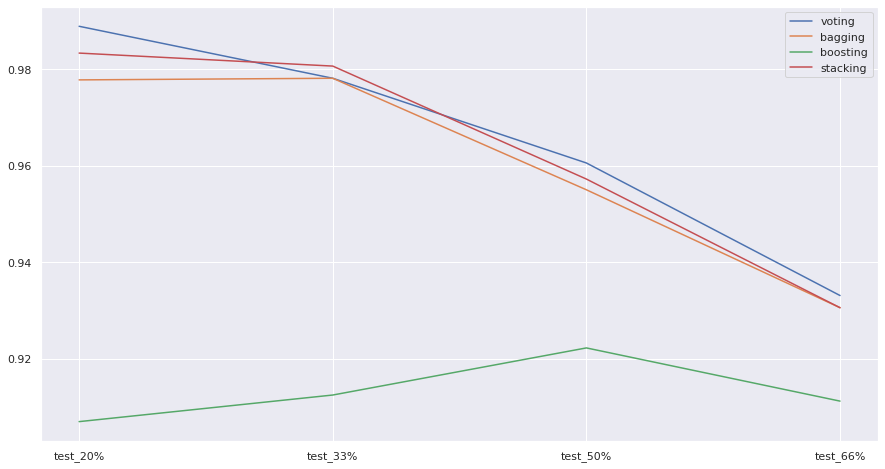

In [275]:
plt.figure(figsize = (15,8))
plt.plot(voting_score_df.columns,list(voting_score_df.loc['accuracy']))
plt.plot(bagging_score_df.columns,list(bagging_score_df.loc['accuracy']))
plt.plot(boosting_score_df.columns,list(boosting_score_df.loc['accuracy']))
plt.plot(stacking_score_df.columns,list(stacking_score_df.loc['accuracy']))
plt.legend(['voting', 'bagging', 'boosting','stacking'])
plt.show()

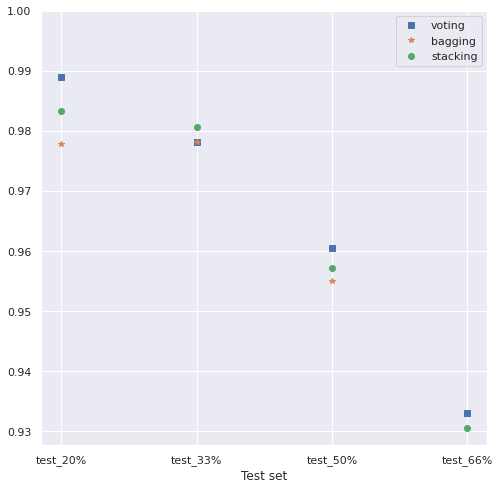

In [276]:
plt.figure(figsize = (8,8))
plt.plot(voting_score_df.columns,list(voting_score_df.loc['accuracy']), 's')
plt.plot(bagging_score_df.columns,list(bagging_score_df.loc['accuracy']), '*')
plt.plot(stacking_score_df.columns,list(stacking_score_df.loc['accuracy']),'o')
plt.legend(['voting', 'bagging', 'stacking'])
plt.axis(ymax=1)
plt.xlabel("Test set")
plt.show()

##<h5><b>9.2) Scelta del modello migliore</b></h5>
<p>L'algoritmo seguente seleziona il modello migliore tra tutte le predizione effettuate in tutti i set, in pratica ci dice quale set dobbiamo utilizzare e con quale algoritmo utilizzarlo</p>

In [277]:
#creazione del dataframe delle accurancy
list_score=[voting_score_df, bagging_score_df, boosting_score_df, stacking_score_df]
name_list=['voting', 'bagging', 'boosting', 'stacking']
accurancy_df=pd.DataFrame()
for i in range(0,4):
  df=list_score[i].transpose()
  label=name_list[i]
  accurancy_df.insert(0, label, df['accuracy'])
accurancy_df

stacking  boosting   bagging    voting
test_20%  0.983333  0.906944  0.977778  0.988889
test_33%  0.980640  0.912458  0.978114  0.978114
test_50%  0.957222  0.922222  0.955000  0.960556
test_66%  0.930556  0.911195  0.930556  0.933081

In [278]:
df2=accurancy_df.transpose()
dict2={}
l=[]
for key in keys_list:
  dict2[key]=df2[df2[key]==df2[key].max()][key].to_dict() #dizionario contenente per ciascun test set l'algoritmo con l'accurancy più elevata
  l.append(list(dict2[key].values())) #lista di appoggio
#trovo il test set con la migliore accuracy
max_model=max(l) 
for test, sub_dict in  dict2.items():
  if(list(sub_dict.values())==max_model): #mi faccio restituire l'algoritmo e il test set migliore
    for model, value in sub_dict.items():
      model_name=model
      test_name=test
print('Il miglior modello è', model_name, ', utilizzando un', test_name)


Il miglior modello è voting , utilizzando un test_20%


In [279]:
#creazione del modello migliore
error=0
if model_name=='voting':
  clf=voting_model
  report=voting_report[test_name]
  predictions=voting_predict[test_name]
  print('voting') #output di debug
elif model_name=='bagging':
  clf=bagging_model
  report=bagging_report[test_name]
  predictions=bagging_predict[test_name]
  print('bagging')
elif model_name=='boosting':
  clf=boosting_model
  report=boosting_report[test_name]
  predictions=boosting_predict[test_name]
  print('boosting')
elif model_name=='stacking':
  clf=stacking_model
  report=stacking_report[test_name]
  predictions=stacking_predict[test_name]
  print('stacking')
else:
  print('Errore nella scelta del modello')
  error=1

voting


In [280]:
#recupero l'indice corretto per le liste 
def get_index_from_test(test_name, name_list):
  c=0
  for key in name_list:
    if key==test_name:
      return c
    c+=1
index=get_index_from_test(test_name, keys_list)
index

0

##<h5><b>9.3) Valutazione del modello</b></h5>
<p> Per valutare il modello è stata usata <code> la matrice di confusione</code> assieme alle relative metriche.

###<h5>9.3.1) Report di classificazione</h5>
<p> Il report di classificazione indica:</p>
<ul>
<li>La precisione: </li>
<li>La recall: </li>
<li> La funzione di f1-score:</li>
<li> La support:</li>
</ul>

In [281]:
if error!=1:
  index_report=[]
  report_precision=[]
  report_recall=[]
  report_f1=[]
  report_support=[]
  for i in range(0,120):
    item=str(i)
    report_precision.append(report[item]['precision'])
    report_recall.append(report[item]['recall'])
    report_f1.append(report[item]['f1-score'])
    report_support.append(report[item]['support'])
    index_report.append(i)




  report_df=pd.DataFrame(report_precision, index=labels, columns=['precision'])
  report_df.insert(len(report_df.columns), 'recall', report_recall)
  report_df.insert(len(report_df.columns), 'f1-score', report_f1)
  report_df.insert(len(report_df.columns), 'support', report_support)
  start=0
  end=60
  while end<=120:  
    display(report_df[start:end])
    print("")
    start=end
    end+=60
else:
  print("Errore: non sono riuscito a calcolare l'algoritmo migliore")

precision  ...  support
Archeologia                                          1.000000  ...        9
Ingegneria informatica                               0.777778  ...        9
Medicina                                             1.000000  ...        7
Scienze e tecniche psicologiche                      0.833333  ...        7
Scienze Biologiche                                   0.833333  ...        5
Ingegneria dei Sistemi Informativi                   0.857143  ...        7
Scienze zootecniche e tecnologie delle produzio...   1.000000  ...        5
Economia e marketing management                      1.000000  ...        8
Beni Culturali                                       1.000000  ...        8
Scienze della formazione primaria                    1.000000  ...        5
Lingue                                               1.000000  ...        5
Ingegneria gestionale                                1.000000  ...        5
Informatica                                          0.714286  ...        6
Ingegneria Informatica elettronica e delle tele...   1.000000  ...        8
Infermieristica                                      1.000000  ...        3
Giurisprudenza                                       1.000000  ...        6
Scienze naturali                                     1.000000  ...        6
Lettere moderne                                      1.000000  ...        5
Comunicazione                                        1.000000  ...       11
Letteratura Musica e Spettacolo (LMS)                1.000000  ...        7
Chimica e Tecnologia Farmaceutiche                   1.000000  ...        6
Scienze e tecnologie alimentari                      1.000000  ...        6
ECONOMIA                                             1.000000  ...        2
Ingegneria medica                                    1.000000  ...        7
Scienze gastronomiche                                1.000000  ...        4
Mediazione Linguistica Interculturale                1.000000  ...        4
Scienze dell’educazione e dei processi formativi     1.000000  ...        7
Graphic Design                                       1.000000  ...       10
Fisica                                               0.888889  ...        8
Clei                                                 1.000000  ...        8
Biologia                                             1.000000  ...        8
Scienze della comunicazione                          1.000000  ...        8
ingegneria meccanica                                 1.000000  ...        5
Biotecnologie                                        1.000000  ...        5
Scienze politiche, Sociali ed Internazionali         1.000000  ...        3
Comunicazione e media per le industrie creative      1.000000  ...        9
digital marketing                                    1.000000  ...        3
Lingue e letterature straniere                       1.000000  ...        5
Ingegneria Elettronica                               1.000000  ...        2
Economia aziendale                                   1.000000  ...        5
Medicina Veterinaria                                 1.000000  ...        2
Farmacia                                             1.000000  ...        6
Statistica matematica e trattamento informatico...   1.000000  ...        8
Lingue e culture europee                             1.000000  ...        6
Lingue e Culture Moderne                             1.000000  ...        8
Economia e finanza                                   1.000000  ...        5
Management                                           1.000000  ...        4
Scienze e tecnologie informatiche                    1.000000  ...        6
Ingegneria                                           1.000000  ...        8
Dams                                                 1.000000  ...       10
Chimica                                              1.000000  ...        5
Scienze della natura e dell'ambiente                 1.000000  ...        6
Beni culturali e spettac

precision  ...  support
Ingegneria elettronica e informatica                      1.0  ...        9
Turismo culturale                                         1.0  ...        3
CIVILTÀ E LINGUE STRANIERE MODERNE                        1.0  ...        4
Scienze dell’educazione e della formazione                1.0  ...        5
Interfacce uomo-macchina e tecnologie della com...        1.0  ...        5
Lettere                                                   1.0  ...        3
Economia e management                                     1.0  ...        8
Storia                                                    1.0  ...        6
Statistica gestionale                                     1.0  ...        5
architettura                                              1.0  ...        8
Design del prodotto industriale                           1.0  ...        4
Comunicazione e Media                                     1.0  ...        5
Scienze Motorie  L-22                                     1.0  ...        7
Biologia Molecolare                                       1.0  ...        8
Scienze giuridiche dell'impresa e delle pubblic...        1.0  ...        3
scienze politiche relazioni internazionali e di...        1.0  ...        8
Gestione aziendale                                        1.0  ...        6
Ingegneria edile e delle costruzioni                      1.0  ...        7
Scienze psicologiche                                      1.0  ...        5
Lingue per l’impresa                                      1.0  ...        4
Economia dei mercati digitali                             1.0  ...        7
Ingegneria chimica e dei materiali                        1.0  ...        6
Servizio sociale                                          1.0  ...        4
Ingegneria ambientale                                     1.0  ...        3
Ingegneria logistica e della Produzione                   1.0  ...        8
Lingue e culture per il turismo e il commercio ...        1.0  ...        7
Marketing Internazionale                                  1.0  ...        8
Studi filosofici                                          1.0  ...        3
Direzione d'impresa                                       1.0  ...        8
Lingua, Cultura, Letteratura e Traduzione                 1.0  ...        7
Scienze del turismo e comunità locale                     1.0  ...        6
Scienze psicologiche per la formazione                    1.0  ...        7
Meccanica                                                 1.0  ...        6
Scienze dell'eduzazione                                   1.0  ...        6
Lettere Musica e Spettacolo                               1.0  ...        3
Scienze e tecnologie per l'ambiente                       1.0  ...        7
MEDIAZIONE LINGUISTICA PER IMPRESE E TURISMO              1.0  ...        7
Psicologia dei processi cognitivi                         1.0  ...        9
Arti e scienze dello spettacolo                           1.0  ...        6
Economia e amministrazione delle imprese                  1.0  ...        5
Economia e management: Nuove tecnologie digitali          1.0  ...        6
Logopedia                                                 1.0  ...        3
Food System                                               1.0  ...        5
Ingegneria delle tecnologie per la salute                 1.0  ...        2
Automazione industriale                                   1.0  ...        6
Marketing management                                      1.0  ...        5
Lingue orientali                                          1.0  ...        7
Scienze ambientali                                        1.0  ...        6
Montaggio Cinematografico e Televisivo                    1.0  ...        5
Dietistica                                                1.0  ...        5
Tecniche della prevenzione nell'ambiente e nei ...        1.0  ...        6
Ostetricia                                                1.0  ...        4
Scienze dell'architettur

###<h5>9.3.2) Grafico di precisione dei risultati</h5>

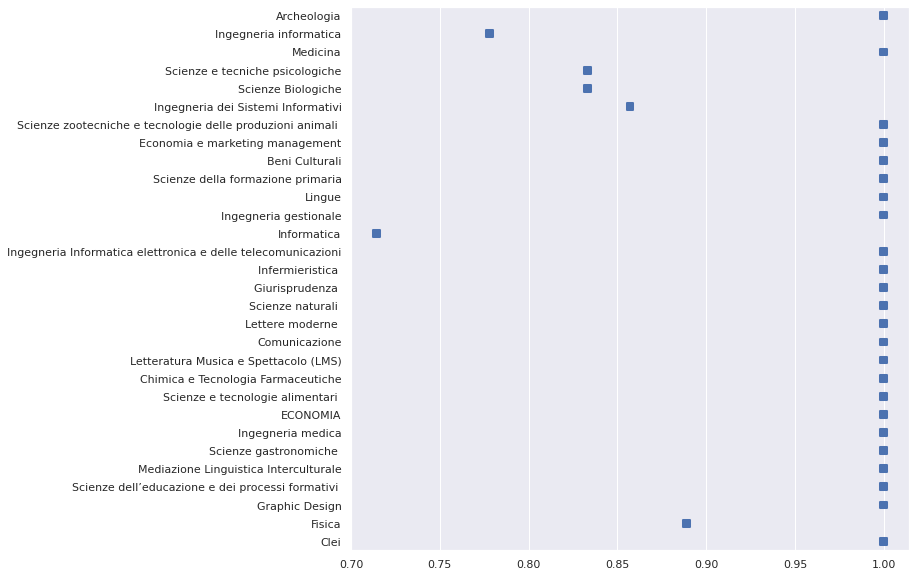

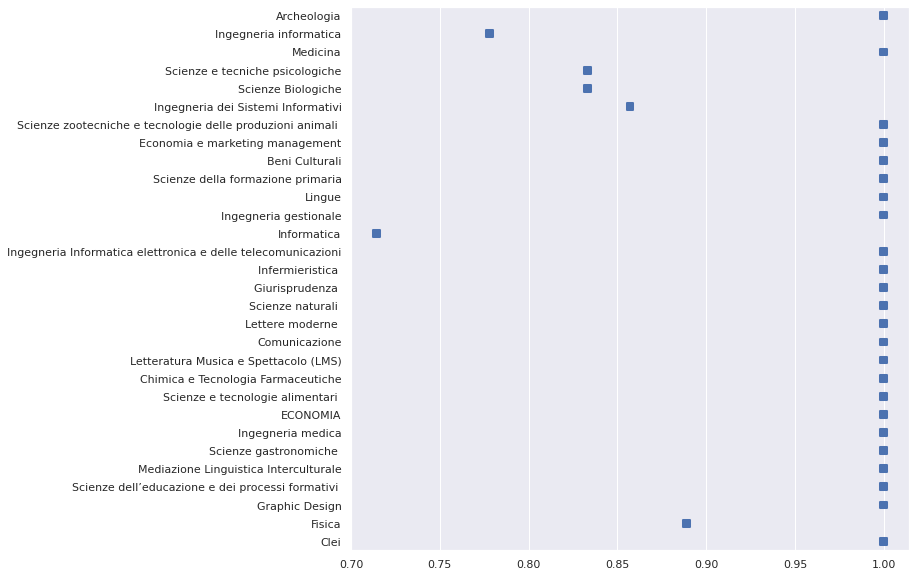

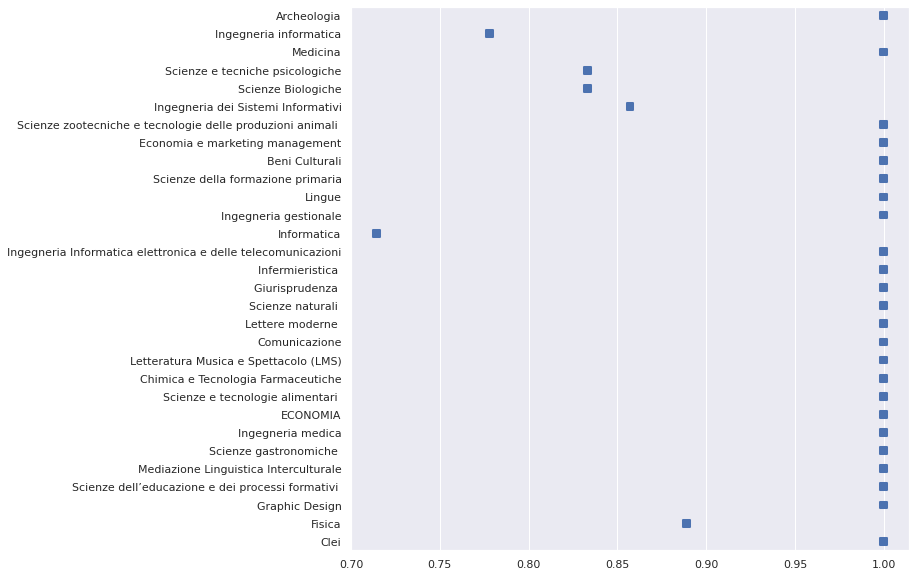

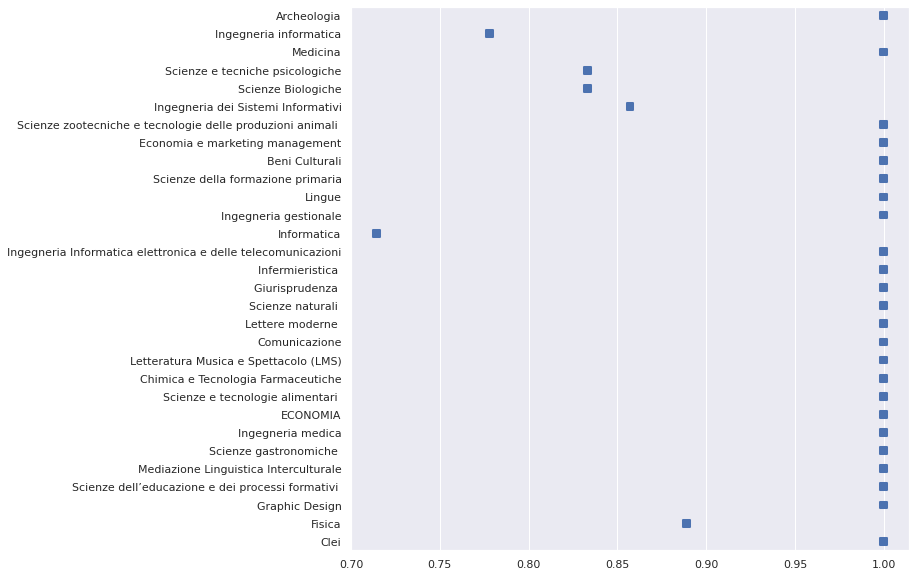

In [282]:
if error!=1:
  start=0
  end=30
  while end <= 120:
    plt.figure(figsize = (10,10))
    sns.set(font_scale=1)
    sns.pointplot( x=report_precision[0:30], y=labels[0:30], markers='s', linestyles='')
    start=end
    end+=30
else:
  print("Errore: non sono riuscito a calcolare l'algoritmo migliore")

###<h5>9.3.1)Matrice di confusione</h5>
<p> La matrice di confusione è stata splittata in 4 grafici per migliorarne la leggibilità</p>

In [283]:
if error!=1:
  cm = confusion_matrix(y_test_list[index], clf.predict(X_test_list[index]))
  print("CM per Test set\n", cm)
else:
  print("Errore: non sono riuscito a calcolare l'algoritmo migliore")

CM per Test set
 [[9 0 0 ... 0 0 0]
 [0 5 0 ... 0 0 0]
 [0 0 7 ... 0 0 0]
 ...
 [0 0 0 ... 4 0 0]
 [0 0 0 ... 0 4 0]
 [0 0 0 ... 0 0 8]]


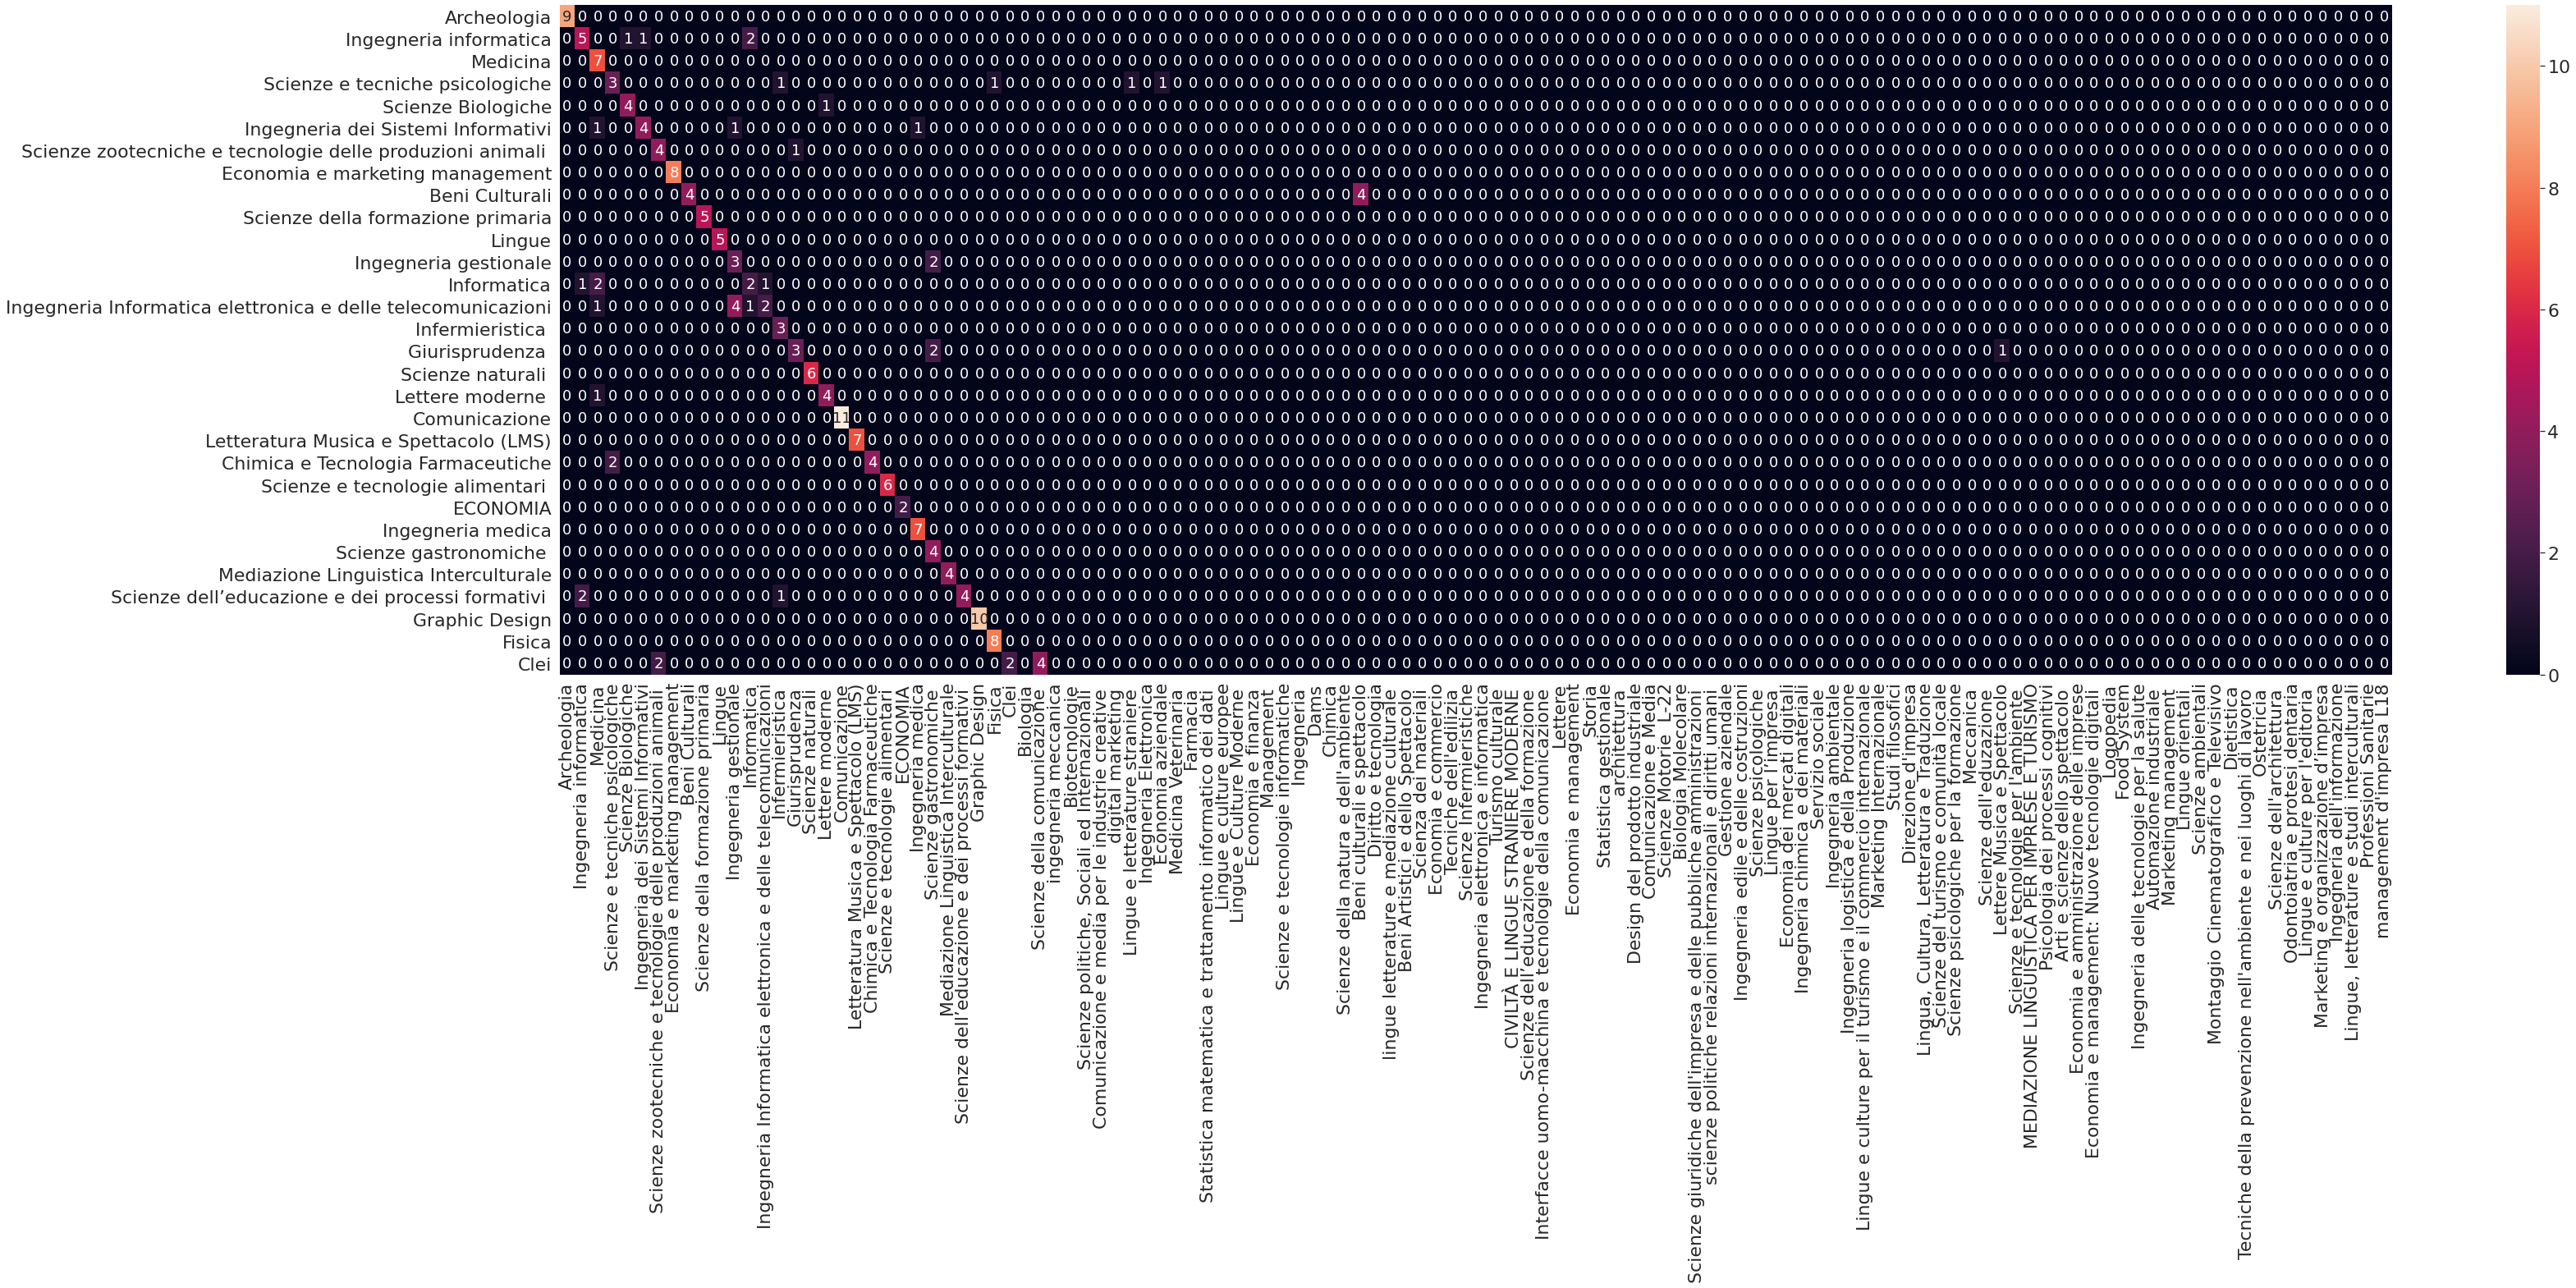

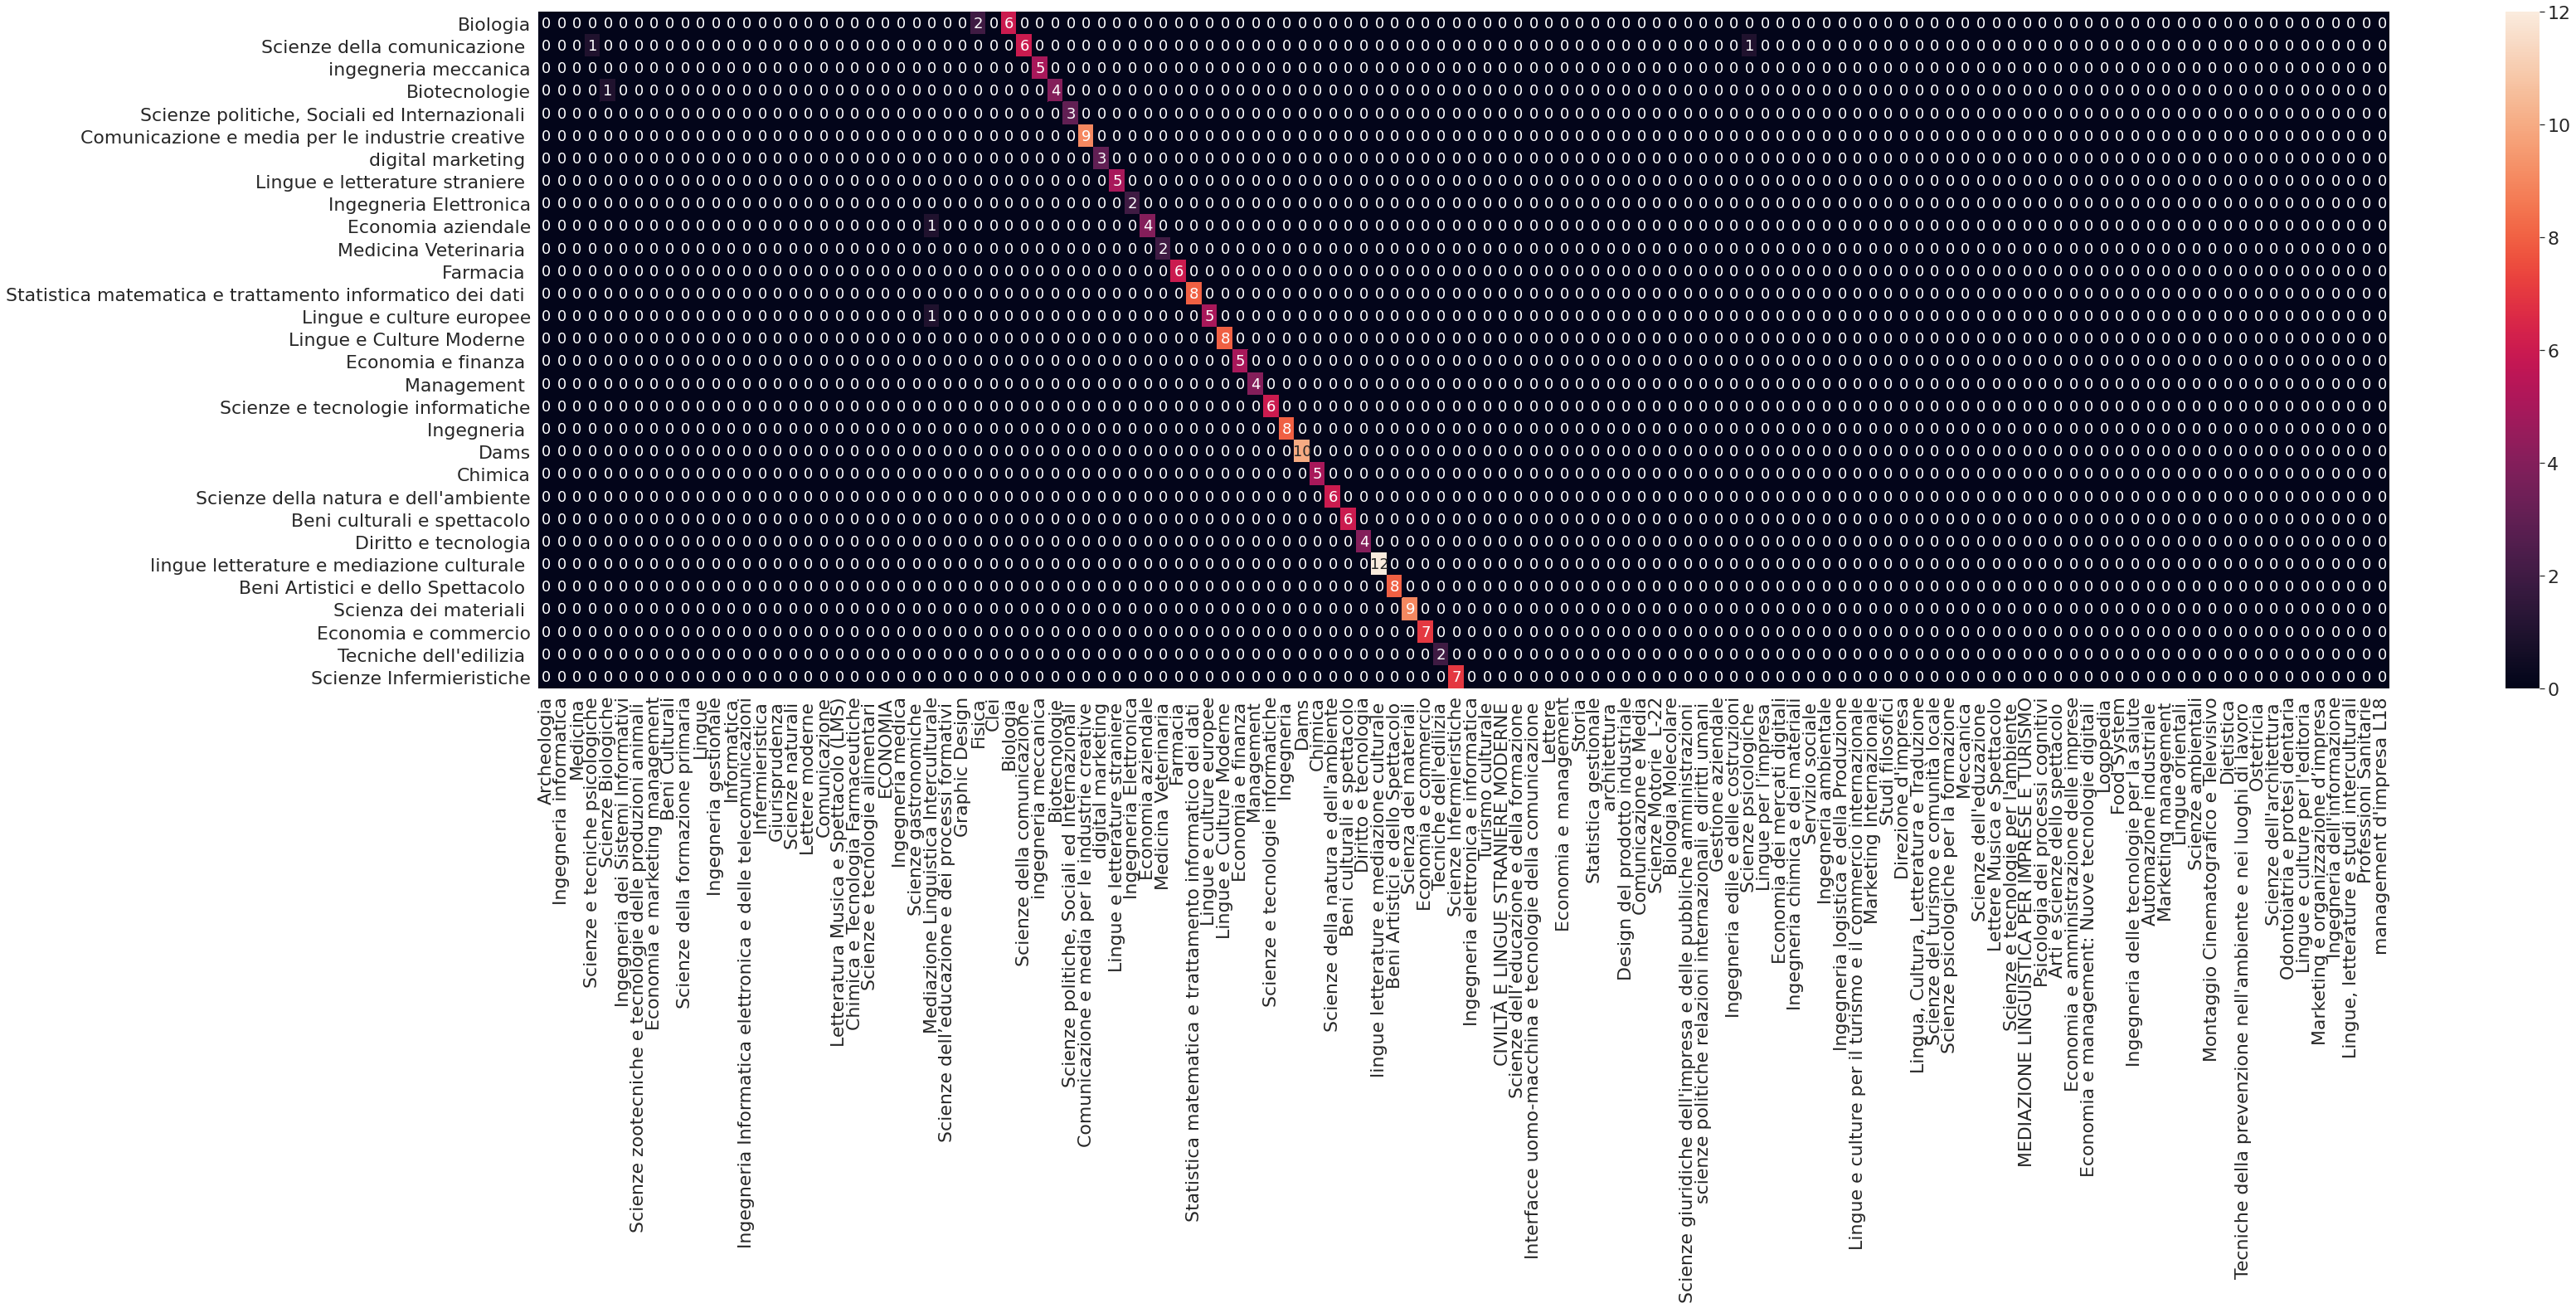

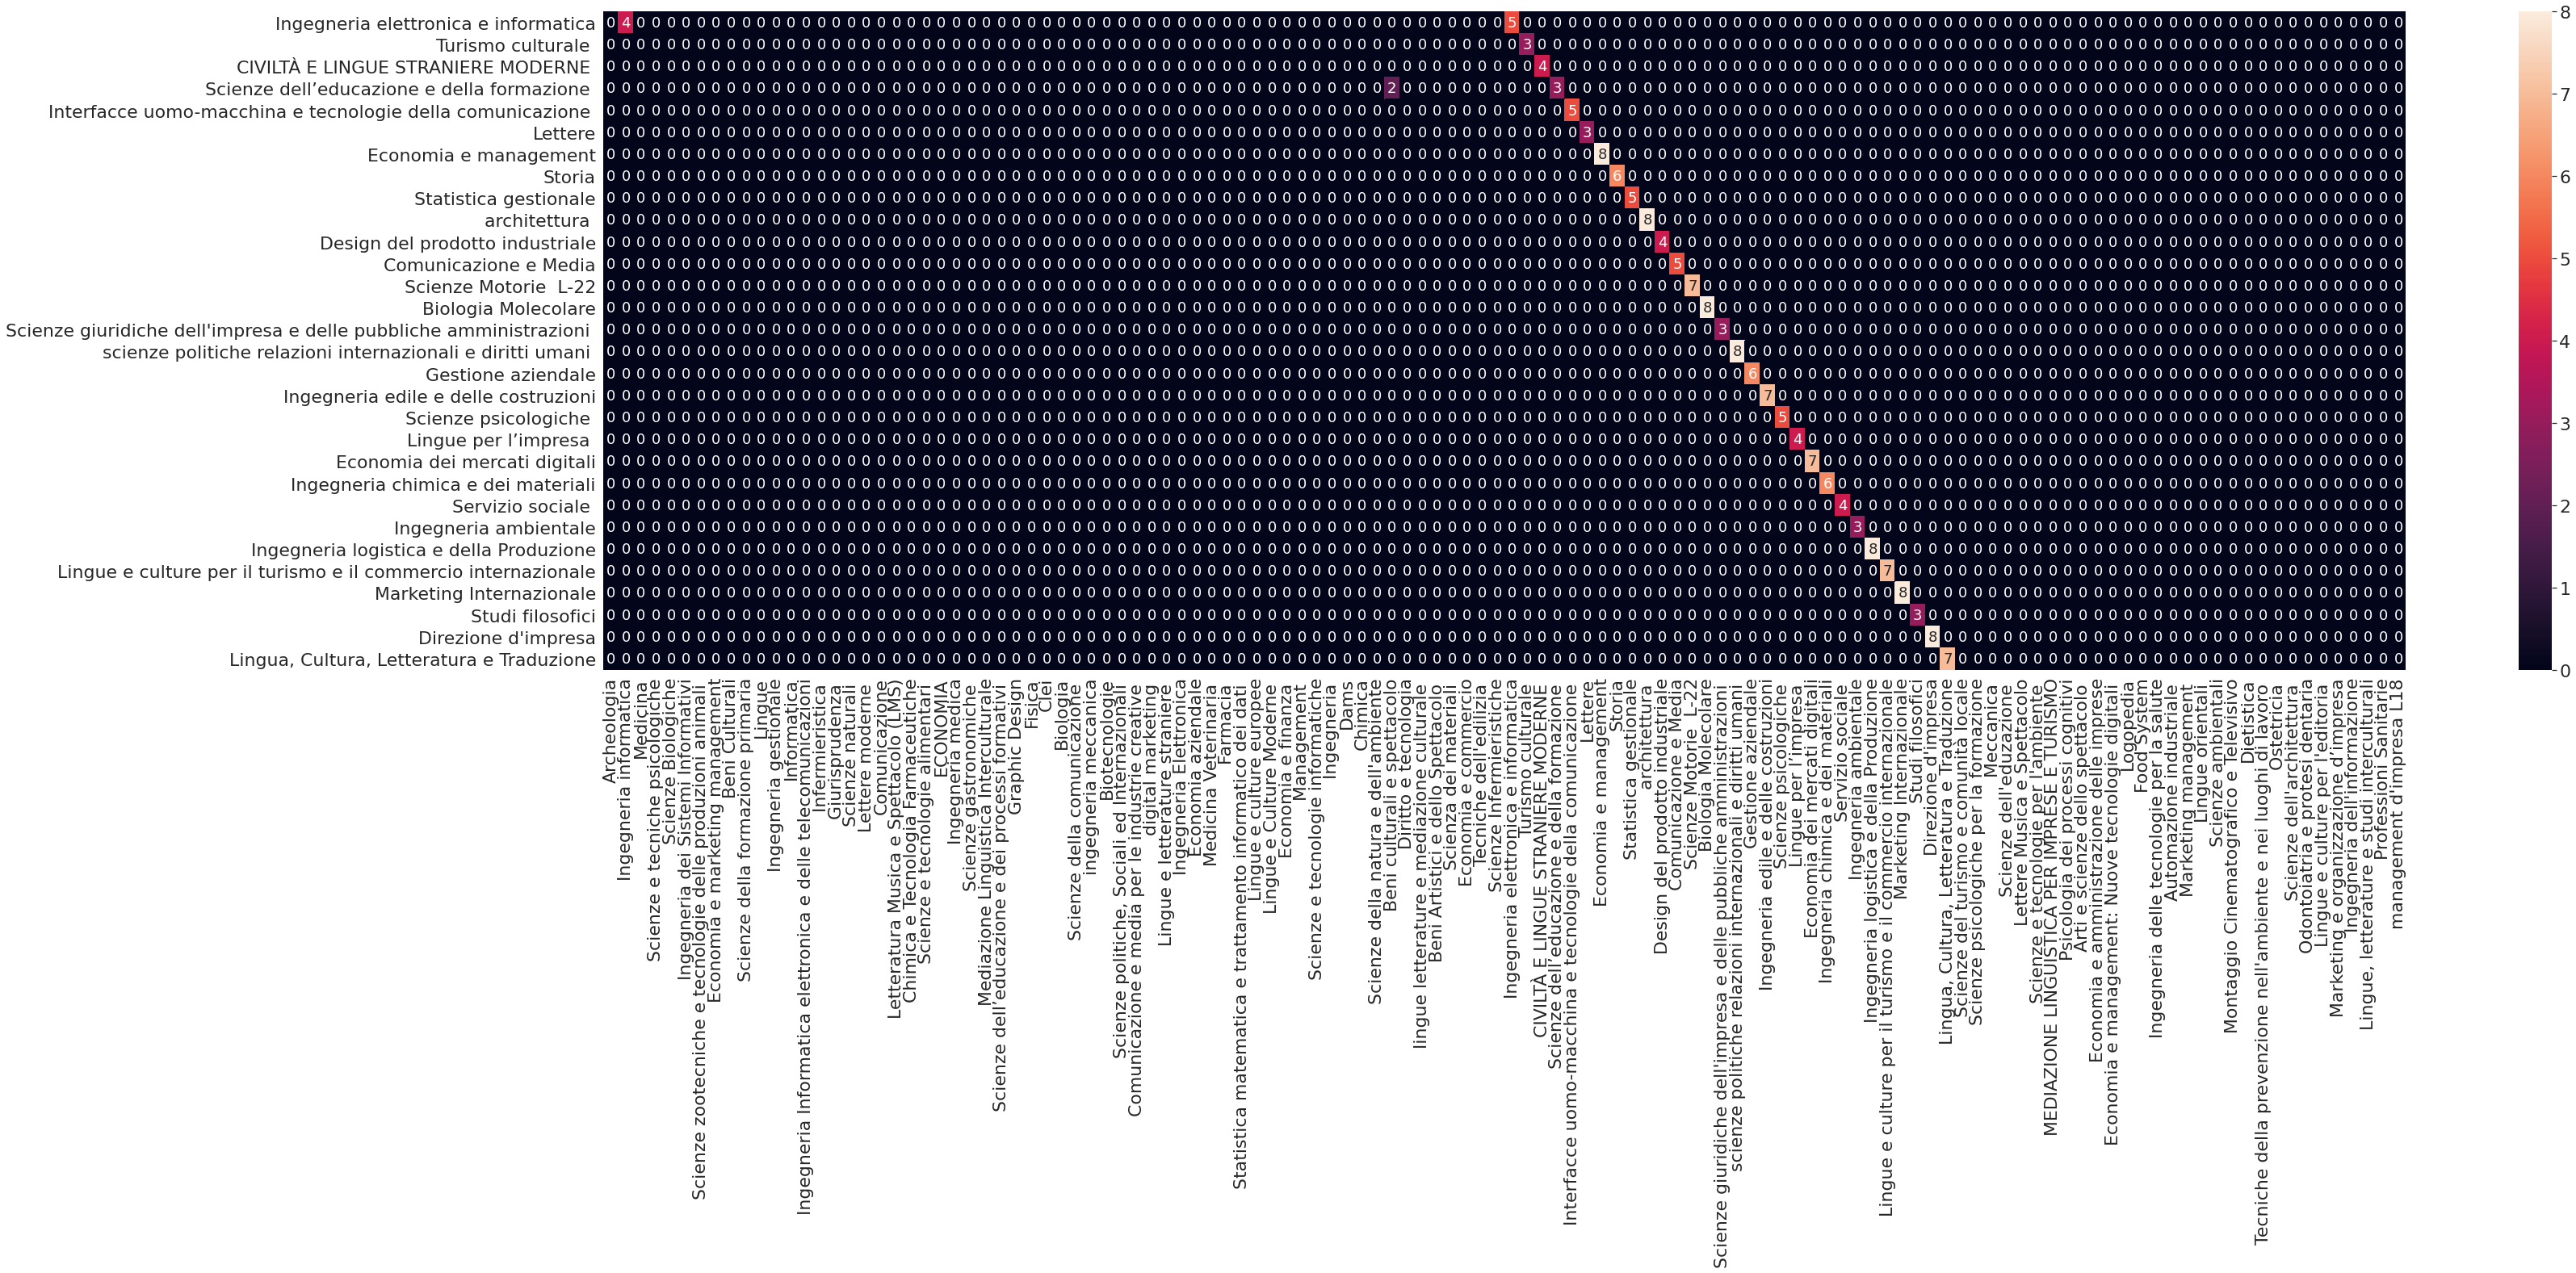

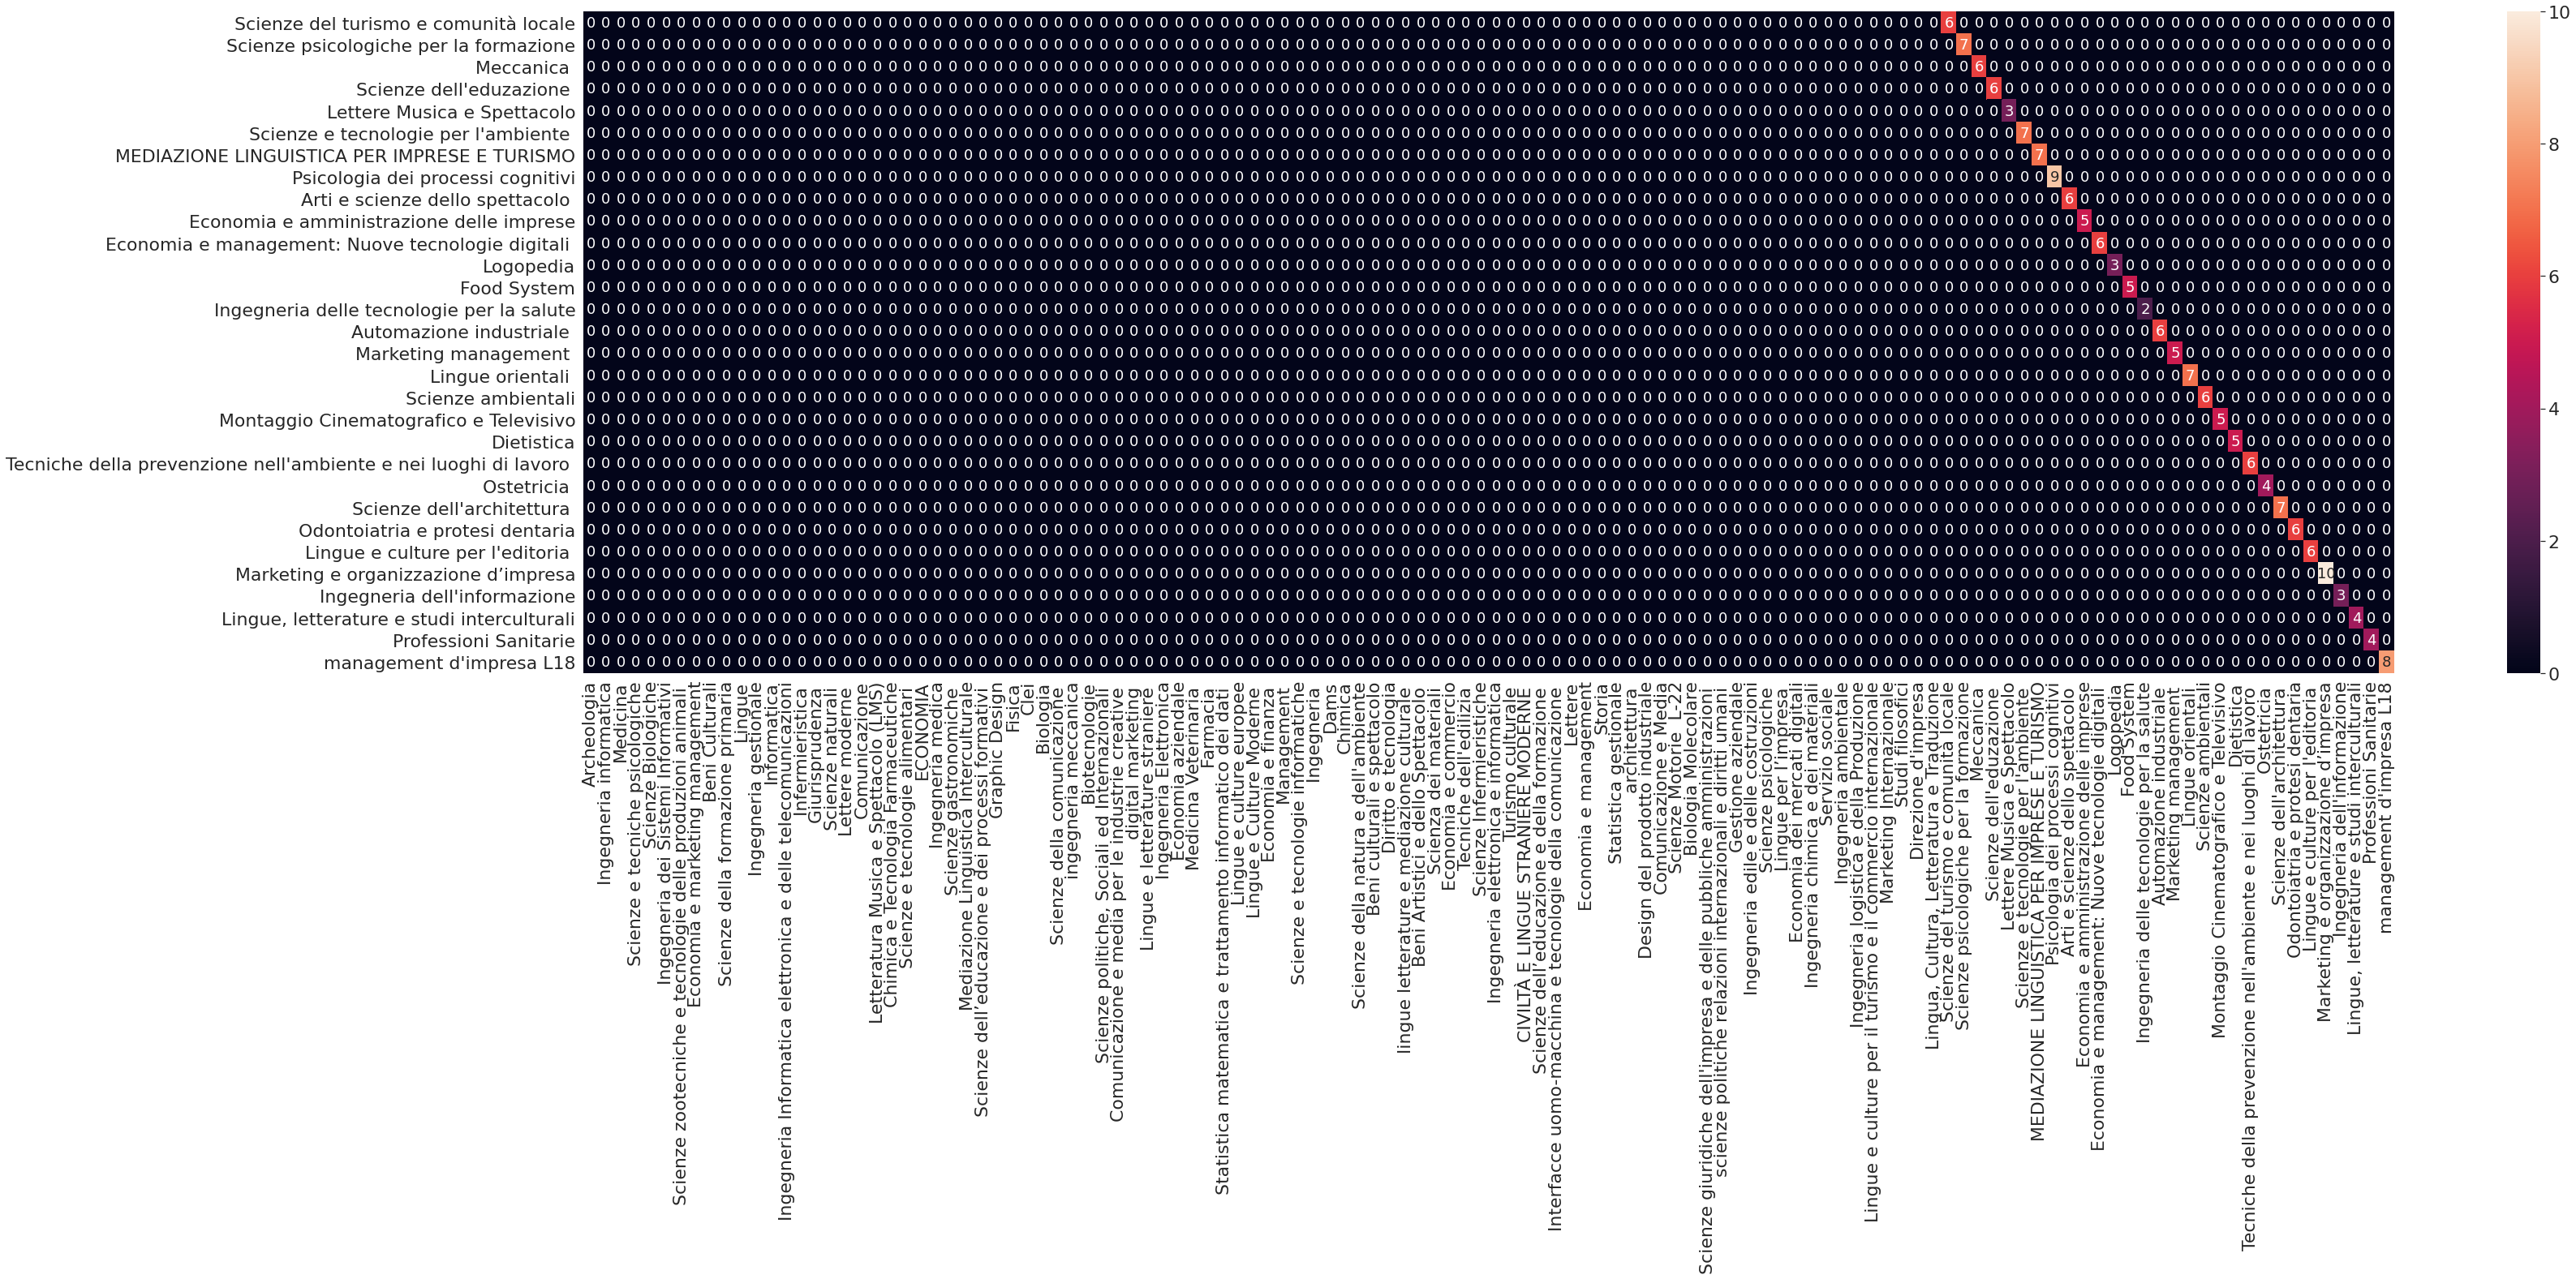

In [284]:
if error!=1:
  start=0
  end=30
  while end <= 120:
    df_cm = pd.DataFrame(cm[start:end, 0:120])
    plt.figure(figsize = (50,15))
    sns.set(font_scale=2)
    sns.heatmap(df_cm, annot=True, fmt="d", annot_kws={"size": 18}, xticklabels=labels[0:120], yticklabels=labels[start:end])# font size
    plt.show()
    start=end
    end+=30
else:
  print("Errore: non sono riuscito a calcolare l'algoritmo migliore")